# Graph analysis for a legislature

## Config

In [3]:
import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.lines as mlines
from itertools import combinations
import math
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from collections import Counter

### Load the JSON files and create the graph

In [4]:
def load_data(deputies_path, votes_path):
    with open(deputies_path, 'r', encoding='utf-8') as f:
        deputies = json.load(f)
    with open(votes_path, 'r', encoding='utf-8') as f:
        votes = json.load(f)
    return {"deputies": deputies, "votes": votes}

In [5]:
def create_graph(deputies, votes):
    G = nx.Graph()
    for deputy_id, deputy_info in deputies.items():
        G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
    co_votes = {}
    deputy_votes = {}
    
    for vote_id, vote_data in votes.items():
        pour_voters = vote_data['votes_for']
        all_voters = set(pour_voters + vote_data['votes_against'] + vote_data['votes_abs'])
        
        for deputy in all_voters:
            if deputy not in deputy_votes:
                deputy_votes[deputy] = set()
            deputy_votes[deputy].add(vote_id)
        
        for i in range(len(pour_voters)):
            for j in range(len(pour_voters)):
                if i != j:
                    deputy1 = pour_voters[i]
                    deputy2 = pour_voters[j]
                    if G.has_node(deputy1) and G.has_node(deputy2):
                        pair = tuple(sorted([deputy1, deputy2]))
                        co_votes[pair] = co_votes.get(pair, 0) + 0.5 

    for (deputy1, deputy2), pour_count in co_votes.items():
        common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
        total_common = len(common_votes)
        if total_common > 0:
            percentage = pour_count / total_common
            G.add_edge(deputy1, deputy2, weight=percentage)
            
    return G

In [6]:
legislature_17 = load_data('data/processed/deputees_17.json', 'data/processed/vote_17.json')
legislature_16 = load_data('data/processed/deputees_16.json', 'data/processed/vote_16.json')
legislature_15 = load_data('data/processed/deputees_15.json', 'data/processed/vote_15.json')
legislature_14 = load_data('data/processed/deputees_14.json', 'data/processed/vote_14.json')

In [7]:
color_14 = {
    'SER': '#FF8080',
    'SRC' : '#FF8080',
    'RRDP': '#FFD1DC',
    'LR': '#0066CC',
    'UDI': '#00FFFF',
    'GDR': '#DD0000',
    'NI': '#AAB1B7'
}

## Utils functions

In [8]:
def print_stats(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        print(f"Graph has {nx.number_connected_components(G)} connected components")

def get_giant_component(G):
    gcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(gcc_nodes).copy()

In [9]:
def plot_network(G, deputies, legislature_num):
    nodes_color = []
    party_colors = {}

    # Construction de la liste des couleurs et du dictionnaire pour la légende
    for node in G.nodes():
        organ_data = deputies[node].get('organ', {})
        party_acronym = organ_data.get('name_short', 'No name')
        
        party_full_name = organ_data.get('name', party_acronym) 

        if str(legislature_num) == '14' and party_acronym in color_14:
            color = color_14[party_acronym]
        else:
            color = organ_data.get('color', '#cccccc')
        
        nodes_color.append(color)
        party_colors[color] = party_full_name
        
    # Normalize edge widths for display
    raw_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(raw_weights) if raw_weights else 1
    widths = [(w / max_w) for w in raw_weights]

    # Create a temporary graph to exaggerate weights for the physics simulation
    G_layout = G.copy()
    for u, v, data in G_layout.edges(data=True):
        data['weight'] = data['weight'] ** 2  # Squaring creates stronger gravity for high weights

    plt.figure(figsize=(12, 8))

    # k=0.5 is the optimal distance (lower k = tighter clusters)
    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)

    nx.draw(G, pos, node_size=100, node_color=nodes_color, edge_color='lightgray', 
            alpha=0.7, with_labels=False, width=widths)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=name, 
                      markerfacecolor=color, markersize=10) 
                      for color, name in party_colors.items()]

    plt.legend(handles=legend_handles, title="Political Parties", 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f"Deputy Voting Network ({str(legislature_num)}'th Legislature)")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_degree_distribution(G):
    degrees = dict(G.degree(weight='weight'))
    degree_values = list(degrees.values())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    degree_counts = Counter(degree_values)
    ks = sorted(degree_counts.keys())
    counts = [degree_counts[k] for k in ks]
    axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [11]:
def get_smooth_polygon(points, iterations=3, padding=1.1):
    """Applies Chaikin's corner cutting algorithm to smooth a polygon."""
    center = np.mean(points, axis=0)
    pts = np.vstack([center + (points - center) * padding, (center + (points - center) * padding)[0]])
    for _ in range(iterations):
        new_pts = []
        for i in range(len(pts) - 1):
            p0, p1 = pts[i], pts[i+1]
            new_pts.extend([0.75 * p0 + 0.25 * p1, 0.25 * p0 + 0.75 * p1])
        pts = np.vstack([new_pts, new_pts[0]])
    return pts

def plot_network_with_communities(G, deputies, legislature_num):
    # Specific color mapping for the 14th legislature

    # 1. Data Preparation
    party_map = {}     # Stores raw organ data for later use (community analysis)
    nodes_color = []   # Ordered list of colors for each node
    legend_data = {}   # Map {Color: Name} for legend and hull outlines

    for node in G.nodes():
        # Retrieve organ data
        organ_data = deputies[node].get('organ', {})
        party_map[node] = organ_data
        
        # Get the acronym (e.g., 'SER', 'LR')
        name_short = organ_data.get('name_short', 'No name')
        
        # --- COLOR LOGIC ---
        # If Legislature 14 AND the acronym is in our custom dictionary
        if str(legislature_num) == '14' and name_short in color_14:
            color = color_14[name_short]
        else:
            # Otherwise, use the color defined in the data, or default to gray
            color = organ_data.get('color', '#cccccc')
        
        nodes_color.append(color)
        legend_data[color] = name_short

    # 2. Layout Calculation (squared weights for clustering)
    G_layout = G.copy()
    for _, _, d in G_layout.edges(data=True): 
        d['weight'] **= 2
    
    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)
    communities = nx.community.louvain_communities(G, weight="weight")

    # 3. Plotting
    fig, ax = plt.subplots(figsize=(20, 14))

    for i, comm in enumerate(communities):
        pts = np.array([pos[n] for n in comm])
        
        # Determine dominant party color within the community
        parties = [party_map[n].get('name_short') for n in comm]
        
        # Fallback color
        col = '#cccccc' 
        
        if parties:
            # Find the most common party in this community
            dom_party = Counter(parties).most_common(1)[0][0]
            # Find the color associated with this party in our updated legend_data
            # (This ensures hull outlines match the overridden colors for Leg 14)
            col = next((c for c, n in legend_data.items() if n == dom_party), '#cccccc')

        # Draw smooth convex hull
        if len(pts) >= 3:
            hull_pts = pts[ConvexHull(pts).vertices]
            # Ensure get_smooth_polygon is defined in your scope
            smooth = get_smooth_polygon(hull_pts, iterations=5, padding=1.25)
            ax.add_patch(Polygon(smooth, facecolor='none', edgecolor=col, linewidth=4, linestyle='--', zorder=2))
            
            # Draw Label
            c_center = np.mean(pts, axis=0)
            ax.text(c_center[0], c_center[1], f"Com. {i}", fontsize=30, fontweight='bold', color=col, 
                    ha='center', va='center', zorder=20, bbox=dict(facecolor='white', edgecolor='none'))

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=120, node_color=nodes_color, edgecolors='white', linewidths=0.5, ax=ax).set_zorder(3)

    # 4. Legend & Layout
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=n, markerfacecolor=c, markersize=15) for c, n in legend_data.items()]
    
    ax.legend(handles=handles, title="Political Parties", loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=math.ceil(len(handles)/2), fontsize=22, title_fontsize=24, frameon=False)
    
    ax.set_title(f"Deputy Voting Network with Communities ({legislature_num}'th Legislature)", fontsize=32, pad=20)
    ax.axis('off')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.18)
    plt.show()

    return communities, nx.community.modularity(G, communities, weight="weight")

In [12]:
def get_party_info(deputies):
    organ_name_dict = {}
    partis_members = {}
    for dep_id, data in deputies.items():
        if data['organ']:
            organ_id = data['organ']['id']
            organ_name_dict[organ_id] = (data['organ']['name'], data['organ']['name_short'])
            if organ_id not in partis_members:
                partis_members[organ_id] = []
            partis_members[organ_id].append(dep_id)
    return organ_name_dict, partis_members

In [13]:
def plot_community_matrix(partis_members, communities_set, organ_name_dict, all_member_ids, legislature_num):
    communities_dict = {f"Com. {i}": comm for i, comm in enumerate(communities_set)}
    community_tuples = []
    sorted_comm_keys = sorted(communities_dict.keys())
    for comm_key in sorted_comm_keys:
        comm_set = communities_dict[comm_key]
        members_in_comm = [item for item in comm_set if item in all_member_ids]
        community_tuples.append((comm_key, members_in_comm))
    
    party_member_lists = list(partis_members.values())
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(num_parti):
        party_i_members = party_member_lists[i]
        for j in range(num_commu):
            community_j_members = community_tuples[j][1]
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            num_party_members = len(party_i_members)
            if num_party_members > 0:
                D[i, j] *= 100 / num_party_members
            else:
                D[i, j] = 0

    x_labels = [f"{t[0]}\n(Size: {len(t[1])})" for t in community_tuples]
    y_labels = [organ_name_dict[g][1] for g in list(partis_members.keys())]
    
    plt.figure(figsize=(max(5, num_commu * 1), max(6, num_parti * 0.8)))
    ax = sns.heatmap(D, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='gray_r', xticklabels=x_labels, yticklabels=y_labels, cbar=False)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=12, fontweight='bold')
    plt.title(f"Proportion of parties in each community (%) \n {str(legislature_num)}'th Legislature", fontsize = 14, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

In [14]:
def analyze_party_proximity(G, partis_members, organ_name_dict, deputies, plot):
    list_partis = list(partis_members.keys())
    proximites_partis = {}
    proximites_without_parties = {} # Between parties
    
    # Between parties
    for i in range(len(list_partis)-1):
        for j in range(i+1, len(list_partis)):
            proximites = []
            for member_i in partis_members[list_partis[i]]:
                for member_j in partis_members[list_partis[j]]:
                    if G.has_node(member_i) and G.has_node(member_j):
                        weigth = 0
                        if G.has_edge(member_i, member_j):
                            weigth = G[member_i][member_j]['weight']

                        proximites_without_parties[(member_i, member_j)] = weigth
                        proximites.append(weigth)
            if proximites:
                proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)

    # Total 
    proximites_debuties = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties[(i, j)] = weight

    # Within parties
    proximites_within_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_parties[(m1, m2)] = weight

    # Of parties
    proximites_of_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
        party_name = organ_name_dict.get(parti, (parti, parti))[1]
        proximites_of_parties[parti] = {"parti": parti, "name": party_name, "combinations": tmp}
        
    if plot:
        G_partis = nx.Graph()
        labels_dict = {}
        for parti_id, members in partis_members.items():
            nom_parti = organ_name_dict.get(parti_id, (parti_id, parti_id))[1]
            G_partis.add_node(parti_id, count=len(members), label_name=nom_parti)
            labels_dict[parti_id] = f"{nom_parti}\n({len(members)})"

        for (p1, p2), dist in proximites_partis.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_partis.add_edge(p1, p2, distance=dist, weight=1.0/safe_dist)

        node_colors = []
        for parti_id in G_partis.nodes():
            color = '#cccccc'
            members = partis_members.get(parti_id, [])
            if members and members[0] in deputies:
                color = deputies[members[0]].get('organ', {}).get('color', '#cccccc')
            node_colors.append(color)

        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G_partis, weight='weight', k=0.6, seed=42)
        nx.draw_networkx_nodes(G_partis, pos, node_size=[G_partis.nodes[n]['count'] * 50 for n in G_partis.nodes()], node_color=node_colors, alpha=0.9, edgecolors='white')
        nx.draw_networkx_labels(G_partis, pos, labels=labels_dict, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G_partis, pos, width=1, alpha=0.3, edge_color='gray')
        plt.axis('off')
        plt.show()
        
        parties_ids = list(G_partis.nodes())
        parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
        dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)
        for (p1, p2), dist in proximites_partis.items():
            if p1 in parties_ids and p2 in parties_ids:
                name1 = G_partis.nodes[p1]['label_name']
                name2 = G_partis.nodes[p2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist
                
        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis_r", linewidths=0.5)
        plt.title("Proximity matrix between parties")
        plt.show()

    print(len(proximites_partis), len(proximites_without_parties), len(proximites_debuties), len(proximites_within_parties), len(proximites_of_parties))

    return proximites_partis, proximites_without_parties, proximites_debuties, proximites_within_parties, proximites_of_parties

In [27]:
import matplotlib.cm as cm

def analyze_community_proximity(G, communities, deputies, plot):

    # Transform list of sets (Louvain) into dictionary {id_comm: [members]}
    # Use list index as community ID
    communities_members = {i: list(members) for i, members in enumerate(communities)}
    list_communities = list(communities_members.keys())
    
    proximites_communities = {}       # Average between communities
    proximites_without_communities = {} # Raw weights between individuals of different communities
    
    # 1. Between communities
    for i in range(len(list_communities)-1):
        for j in range(i+1, len(list_communities)):
            proximites = []
            comm_i_id = list_communities[i]
            comm_j_id = list_communities[j]
            
            for member_i in communities_members[comm_i_id]:
                for member_j in communities_members[comm_j_id]:
                    # Verify that nodes exist in the filtered graph
                    if G.has_node(member_i) and G.has_node(member_j):
                        weight = 0
                        if G.has_edge(member_i, member_j):
                            weight = G[member_i][member_j]['weight']

                        proximites_without_communities[(member_i, member_j)] = weight
                        proximites.append(weight)
            
            # Store the mean if there are connections or compared pairs
            if proximites:
                proximites_communities[(comm_i_id, comm_j_id)] = np.mean(proximites)

    # 2. Total (All pairs combined)
    proximites_deputies = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_deputies[(i, j)] = weight

    # 3. Within communities
    proximites_within_communities = {}
    for comm_id in list_communities:
        members = [m for m in communities_members.get(comm_id, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_communities[(m1, m2)] = weight

    # 4. Of communities (Detail per community)
    proximites_of_communities = {}
    for comm_id in list_communities:
        members = [m for m in communities_members.get(comm_id, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
            
        comm_name = f"Comm {comm_id}"
        proximites_of_communities[comm_id] = {
            "community_id": comm_id, 
            "name": comm_name, 
            "combinations": tmp
        }
        
    # --- PLOTTING ---
    if plot:
        G_comm = nx.Graph()
        labels_dict = {}
        
        # Generate a color palette for the communities
        cmap = cm.get_cmap('tab20', len(communities_members))
        
        for comm_id, members in communities_members.items():
            comm_name = f"Comm {comm_id}"
            # Add node representing the community
            G_comm.add_node(comm_id, count=len(members), label_name=comm_name)
            labels_dict[comm_id] = f"{comm_name}\n({len(members)})"

        # Add edges (distance inversely proportional to average weight)
        for (c1, c2), dist in proximites_communities.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_comm.add_edge(c1, c2, distance=dist, weight=1.0/safe_dist)

        # Node colors
        node_colors = [cmap(i) for i in range(len(G_comm.nodes()))]

        # 1st Plot: Community Graph
        plt.figure(figsize=(14, 10))
        # Layout based on weight (proximity)
        pos = nx.spring_layout(G_comm, weight='weight', k=0.6, seed=42)
        
        nx.draw_networkx_nodes(G_comm, pos, 
                               node_size=[G_comm.nodes[n]['count'] * 50 for n in G_comm.nodes()], 
                               node_color=node_colors, 
                               alpha=0.9, 
                               edgecolors='white')
        
        nx.draw_networkx_labels(G_comm, pos, labels=labels_dict, font_size=9, font_weight='bold')
        
        # Draw edges with width proportional to proximity
        edges = G_comm.edges(data=True)
        weights = [edata['distance']*10 for u, v, edata in edges] # Scaling factor for visibility
        nx.draw_networkx_edges(G_comm, pos, width=weights, alpha=0.3, edge_color='gray')
        
        # Add edge labels (proximity values)
        edge_labels = nx.get_edge_attributes(G_comm, 'distance')
        # Format labels to show only 2 decimal places
        formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G_comm, pos, edge_labels=formatted_edge_labels, font_size=8, font_color='red')

        plt.title("Network of Communities (Proximity based on average edge weight)")
        plt.axis('off')
        plt.show()
        
        # 2nd Plot: Heatmap (Distance/Proximity Matrix)
        comm_ids = list(G_comm.nodes())
        comm_names = [G_comm.nodes[cid]['label_name'] for cid in comm_ids]
        
        dist_matrix = pd.DataFrame(np.nan, index=comm_names, columns=comm_names)
        
        for (c1, c2), dist in proximites_communities.items():
            if c1 in comm_ids and c2 in comm_ids:
                # Find index (name) corresponding to ID
                name1 = G_comm.nodes[c1]['label_name']
                name2 = G_comm.nodes[c2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist
                
        # Fill diagonal (average internal proximity)
        for comm_id in comm_ids:
            name = G_comm.nodes[comm_id]['label_name']
            if comm_id in proximites_of_communities:
                vals = list(proximites_of_communities[comm_id]['combinations'].values())
                if vals:
                    dist_matrix.loc[name, name] = np.mean(vals)
                
        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
        plt.title("Proximity matrix between Communities")
        plt.show()

    print(f"Stats: {len(proximites_communities)} inter-comm links, {len(proximites_without_communities)} raw pairs, {len(proximites_deputies)} total pairs.")

    return proximites_communities, proximites_without_communities, proximites_deputies, proximites_within_communities, proximites_of_communities

In [16]:
def calculate_party_modularity(G, partis_members):
    nodes_in_graph = set(G.nodes())
    cleaned_parti_com = []
    for members in partis_members.values():
        valid_members = [m for m in members if m in nodes_in_graph]
        if valid_members:
            cleaned_parti_com.append(valid_members)
    print(f"Modularity score - partis : {nx.community.modularity(G, cleaned_parti_com, weight='weight')}")

In [17]:
def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def plot_proximity_comparison(prox_between, prox_total, prox_within, prox_of_parties, deputies, legislature_id):
    plt.figure(figsize=(14, 9))
    
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.1, color='grey', linestyle='--', linewidth=2)
    sns.kdeplot(list(prox_within.values()), label='Within Parties (All)', fill=True, alpha=0.1, color='black', linewidth=2)
    #sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.1)

    party_colors = {}
    for dep in deputies.values():
        if dep.get('organ'):
            party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

    for party_id, data in prox_of_parties.items():
        vals = list(data['combinations'].values())
        if len(vals) > 5: # Filter slightly to avoid KDE errors on very few points
            color = party_colors.get(party_id, '#cccccc')
            sns.kdeplot(vals, label=f"{data['name']}", color=color, linestyle=':', linewidth=3.5, alpha=0.9)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}', fontsize=16)
    plt.xlabel('Proximity (Weight)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

## Setup

In [18]:
G_17 = get_giant_component(create_graph(legislature_17["deputies"], legislature_17["votes"]))
G_16 = get_giant_component(create_graph(legislature_16["deputies"], legislature_16["votes"]))
G_15 = get_giant_component(create_graph(legislature_15["deputies"], legislature_15["votes"]))
G_14 = get_giant_component(create_graph(legislature_14["deputies"], legislature_14["votes"]))

In [19]:
organ_name_dict_17, partis_members_17 = get_party_info(legislature_17["deputies"])
organ_name_dict_16, partis_members_16 = get_party_info(legislature_16["deputies"])
organ_name_dict_15, partis_members_15 = get_party_info(legislature_15["deputies"])
organ_name_dict_14, partis_members_14 = get_party_info(legislature_14["deputies"])

In [20]:
proximites_partis_17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17 = analyze_party_proximity(G_17, partis_members_17, organ_name_dict_17, legislature_17["deputies"], False)
proximites_partis_16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16 = analyze_party_proximity(G_16, partis_members_16, organ_name_dict_16, legislature_16["deputies"], False)
proximites_partis_15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15 = analyze_party_proximity(G_15, partis_members_15, organ_name_dict_15, legislature_15["deputies"], False)
proximites_partis_14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14 = analyze_party_proximity(G_14, partis_members_14, organ_name_dict_14, legislature_14["deputies"], False)

66 159619 181503 21884 12
55 153933 182710 28777 11
78 154345 208981 54636 13
36 136482 201295 64813 9


## Legislature analysis

### Legislature 17

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\1348156239.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


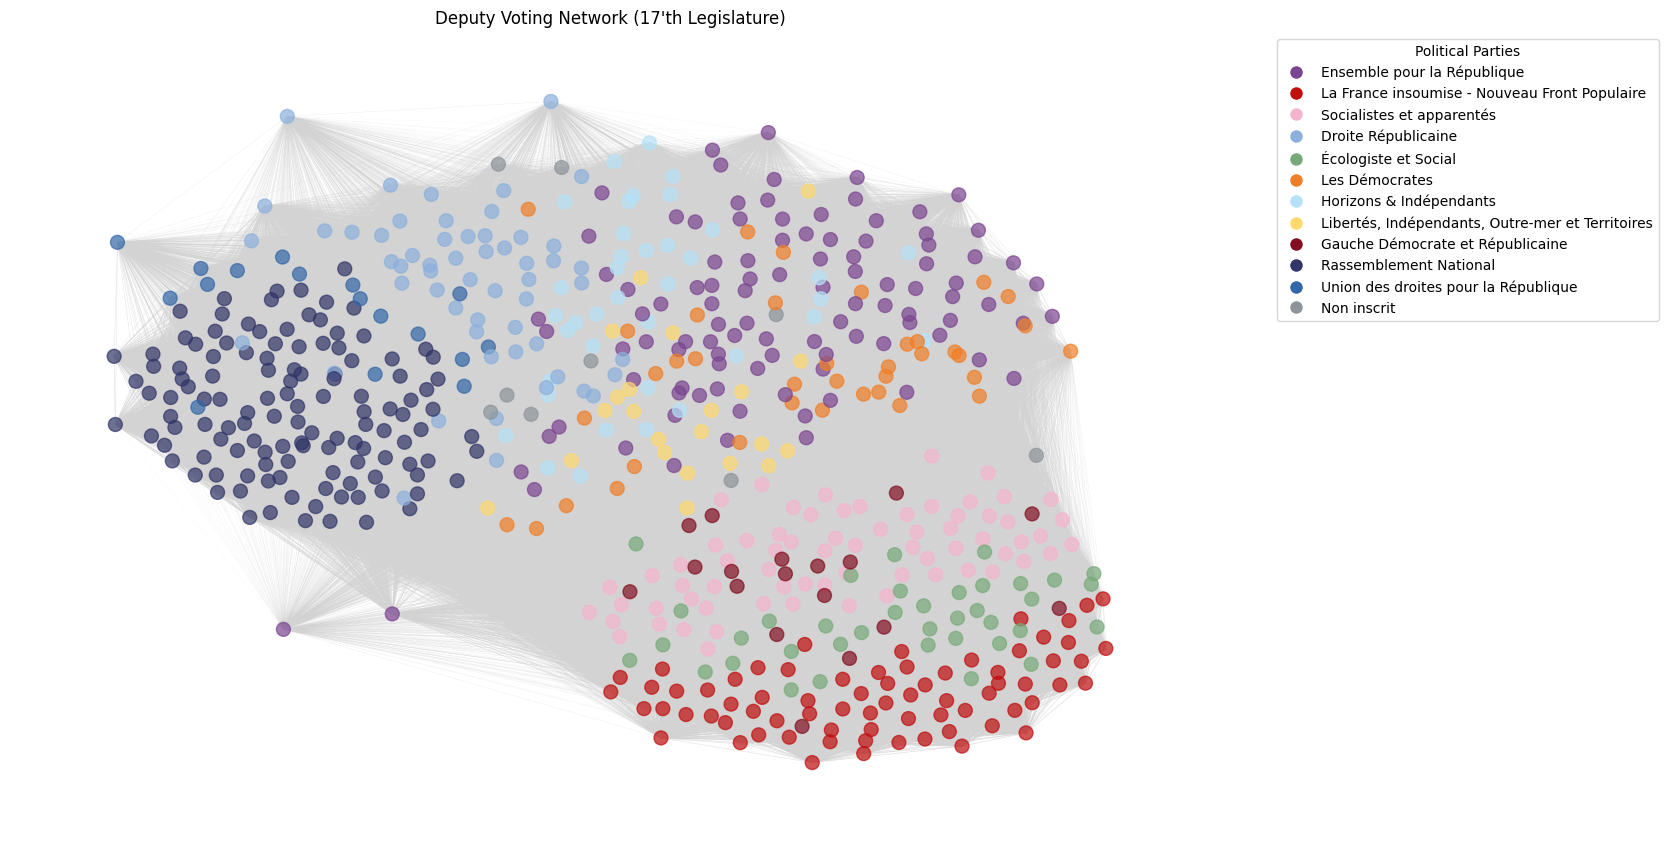

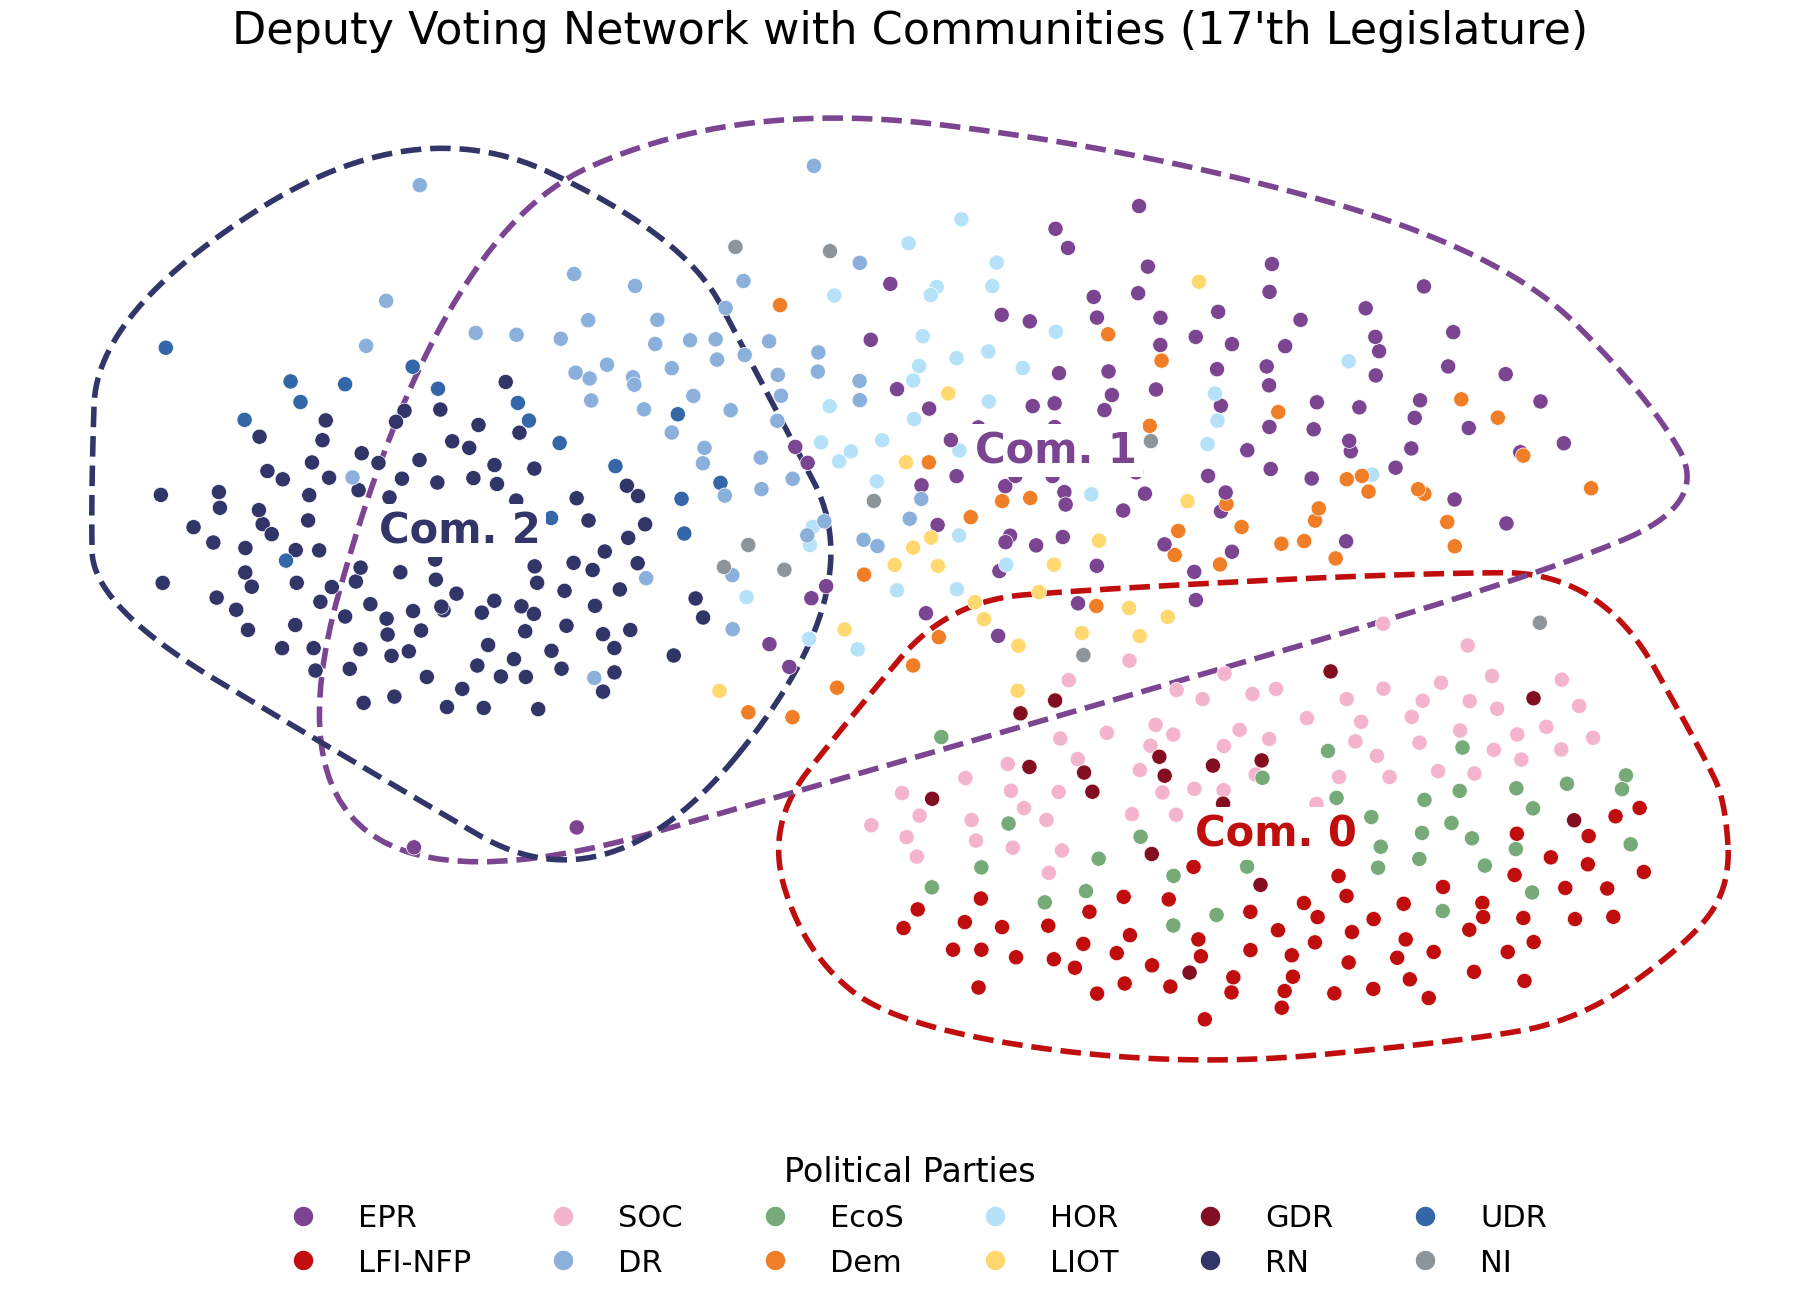

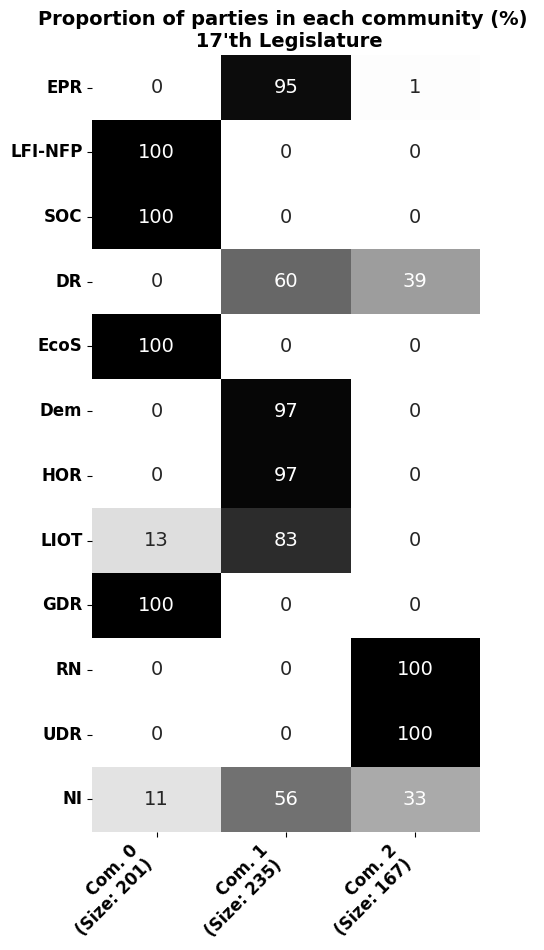

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\2970071050.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


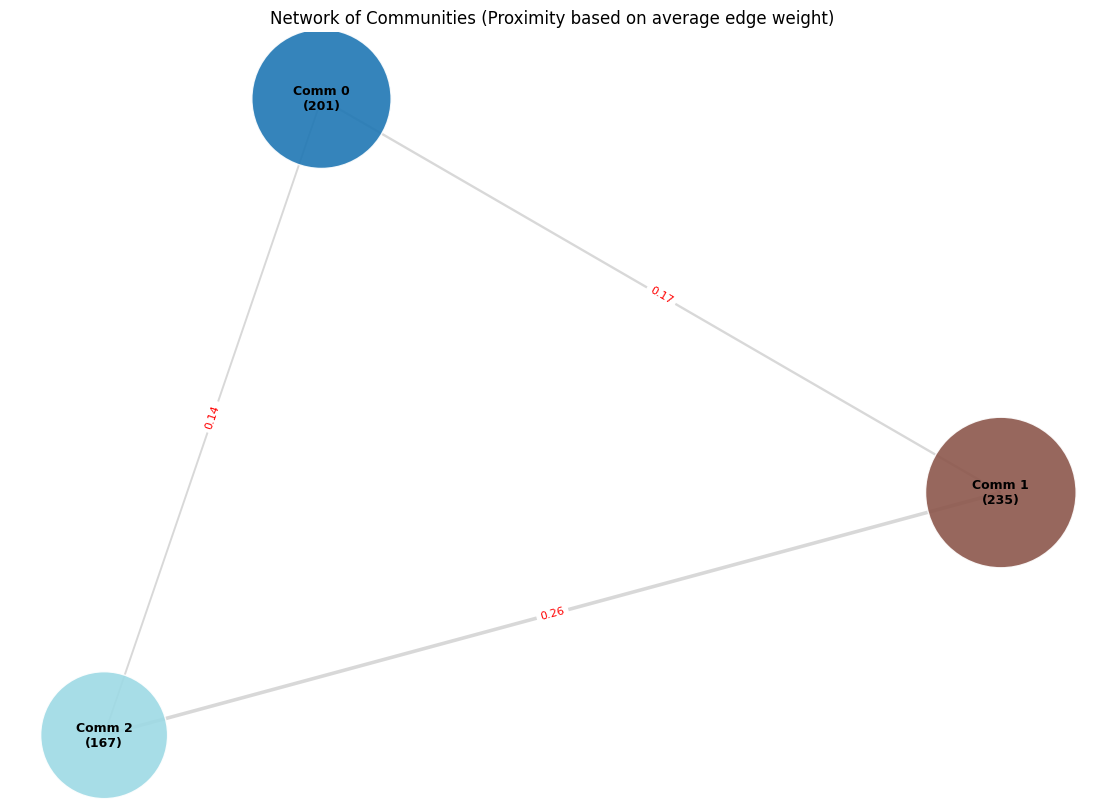

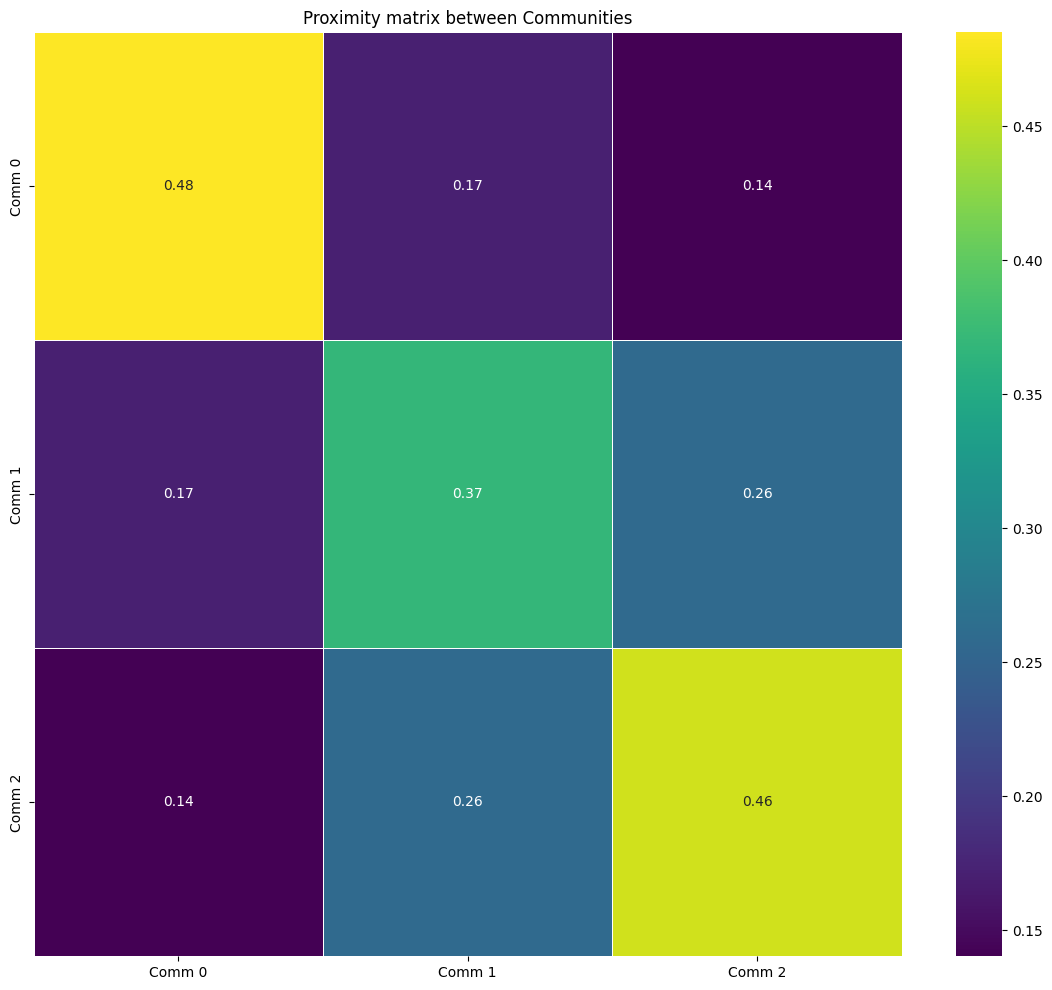

Stats: 3 inter-comm links, 120047 raw pairs, 181503 total pairs.


({(0, 1): np.float64(0.17024469419227212),
  (0, 2): np.float64(0.1402694405588221),
  (1, 2): np.float64(0.25848515795794913)},
 {('PA794166', 'PA721764'): 0.0891891891891892,
  ('PA794166', 'PA757225'): 0.12643678160919541,
  ('PA794166', 'PA721486'): 0.0967741935483871,
  ('PA794166', 'PA721816'): 0.06802721088435375,
  ('PA794166', 'PA607193'): 0.10897435897435898,
  ('PA794166', 'PA840713'): 0.16822429906542055,
  ('PA794166', 'PA793270'): 0.15251299826689774,
  ('PA794166', 'PA718784'): 0.12121212121212122,
  ('PA794166', 'PA267780'): 0.11883408071748879,
  ('PA794166', 'PA722252'): 0.15702479338842976,
  ('PA794166', 'PA722102'): 0.10364145658263306,
  ('PA794166', 'PA794470'): 0.06073752711496746,
  ('PA794166', 'PA721024'): 0.06274509803921569,
  ('PA794166', 'PA795402'): 0.10619469026548672,
  ('PA794166', 'PA719798'): 0.10638297872340426,
  ('PA794166', 'PA721004'): 0.17708333333333334,
  ('PA794166', 'PA607395'): 0.1773049645390071,
  ('PA794166', 'PA795330'): 0.15198237885

In [28]:
plot_network(G_17, legislature_17["deputies"], 17)
communities_set, modularity_score = plot_network_with_communities(G_17,legislature_17["deputies"], 17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()), 17)

analyze_community_proximity(G_17, communities_set, legislature_17["deputies"], plot=True)

### Legislature 16

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\1348156239.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


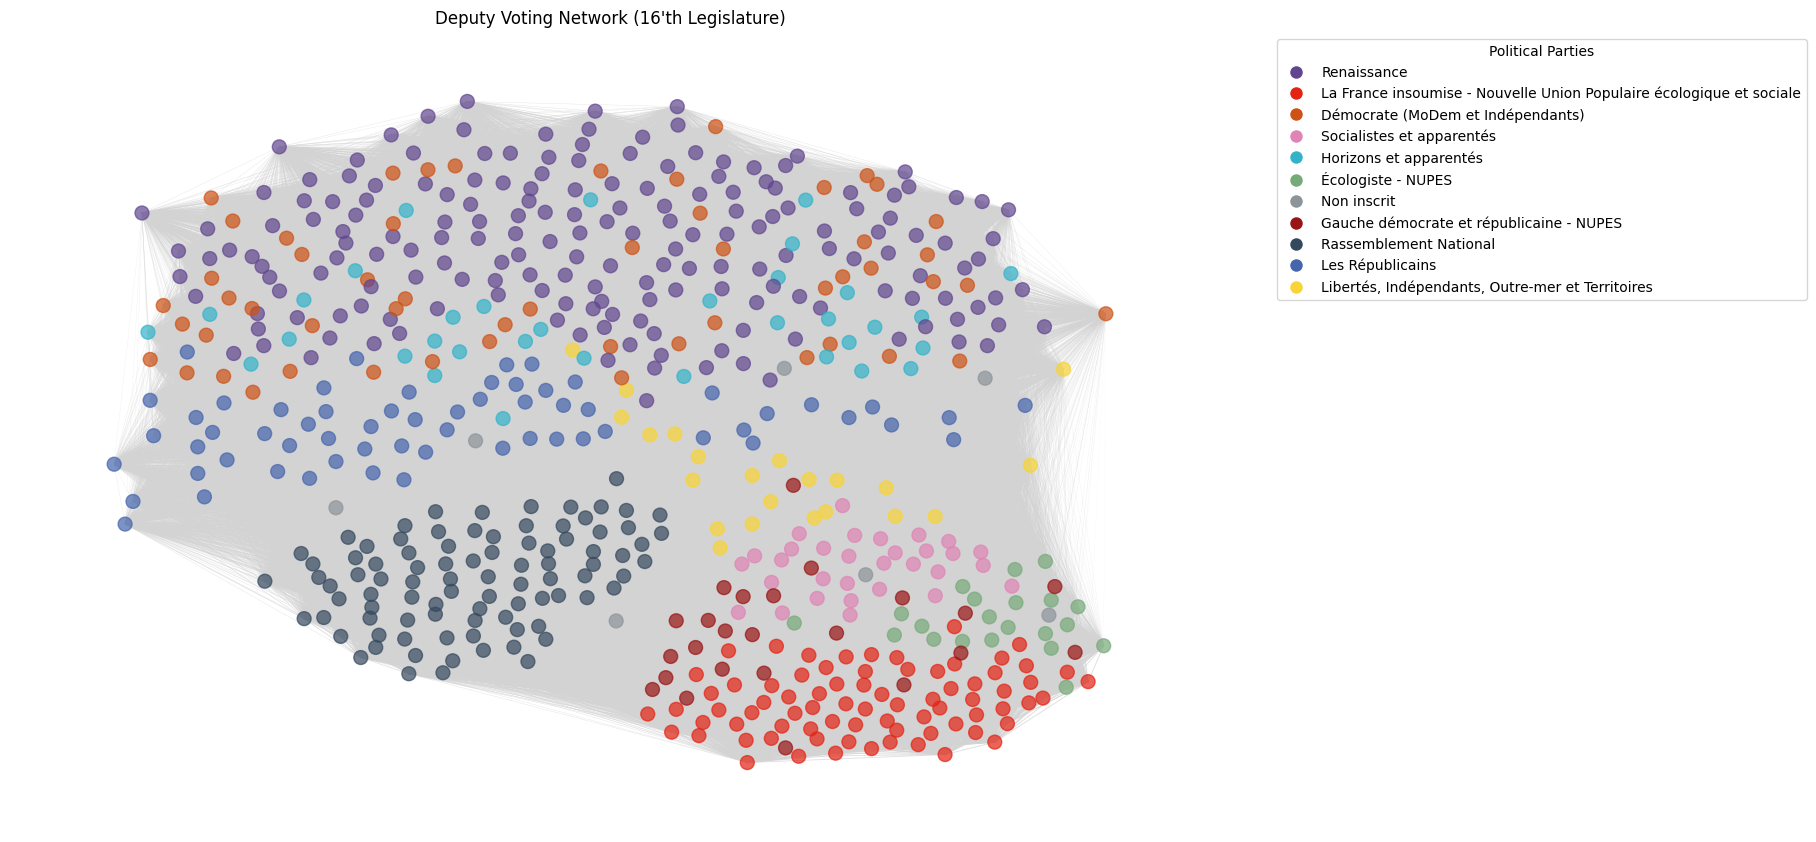

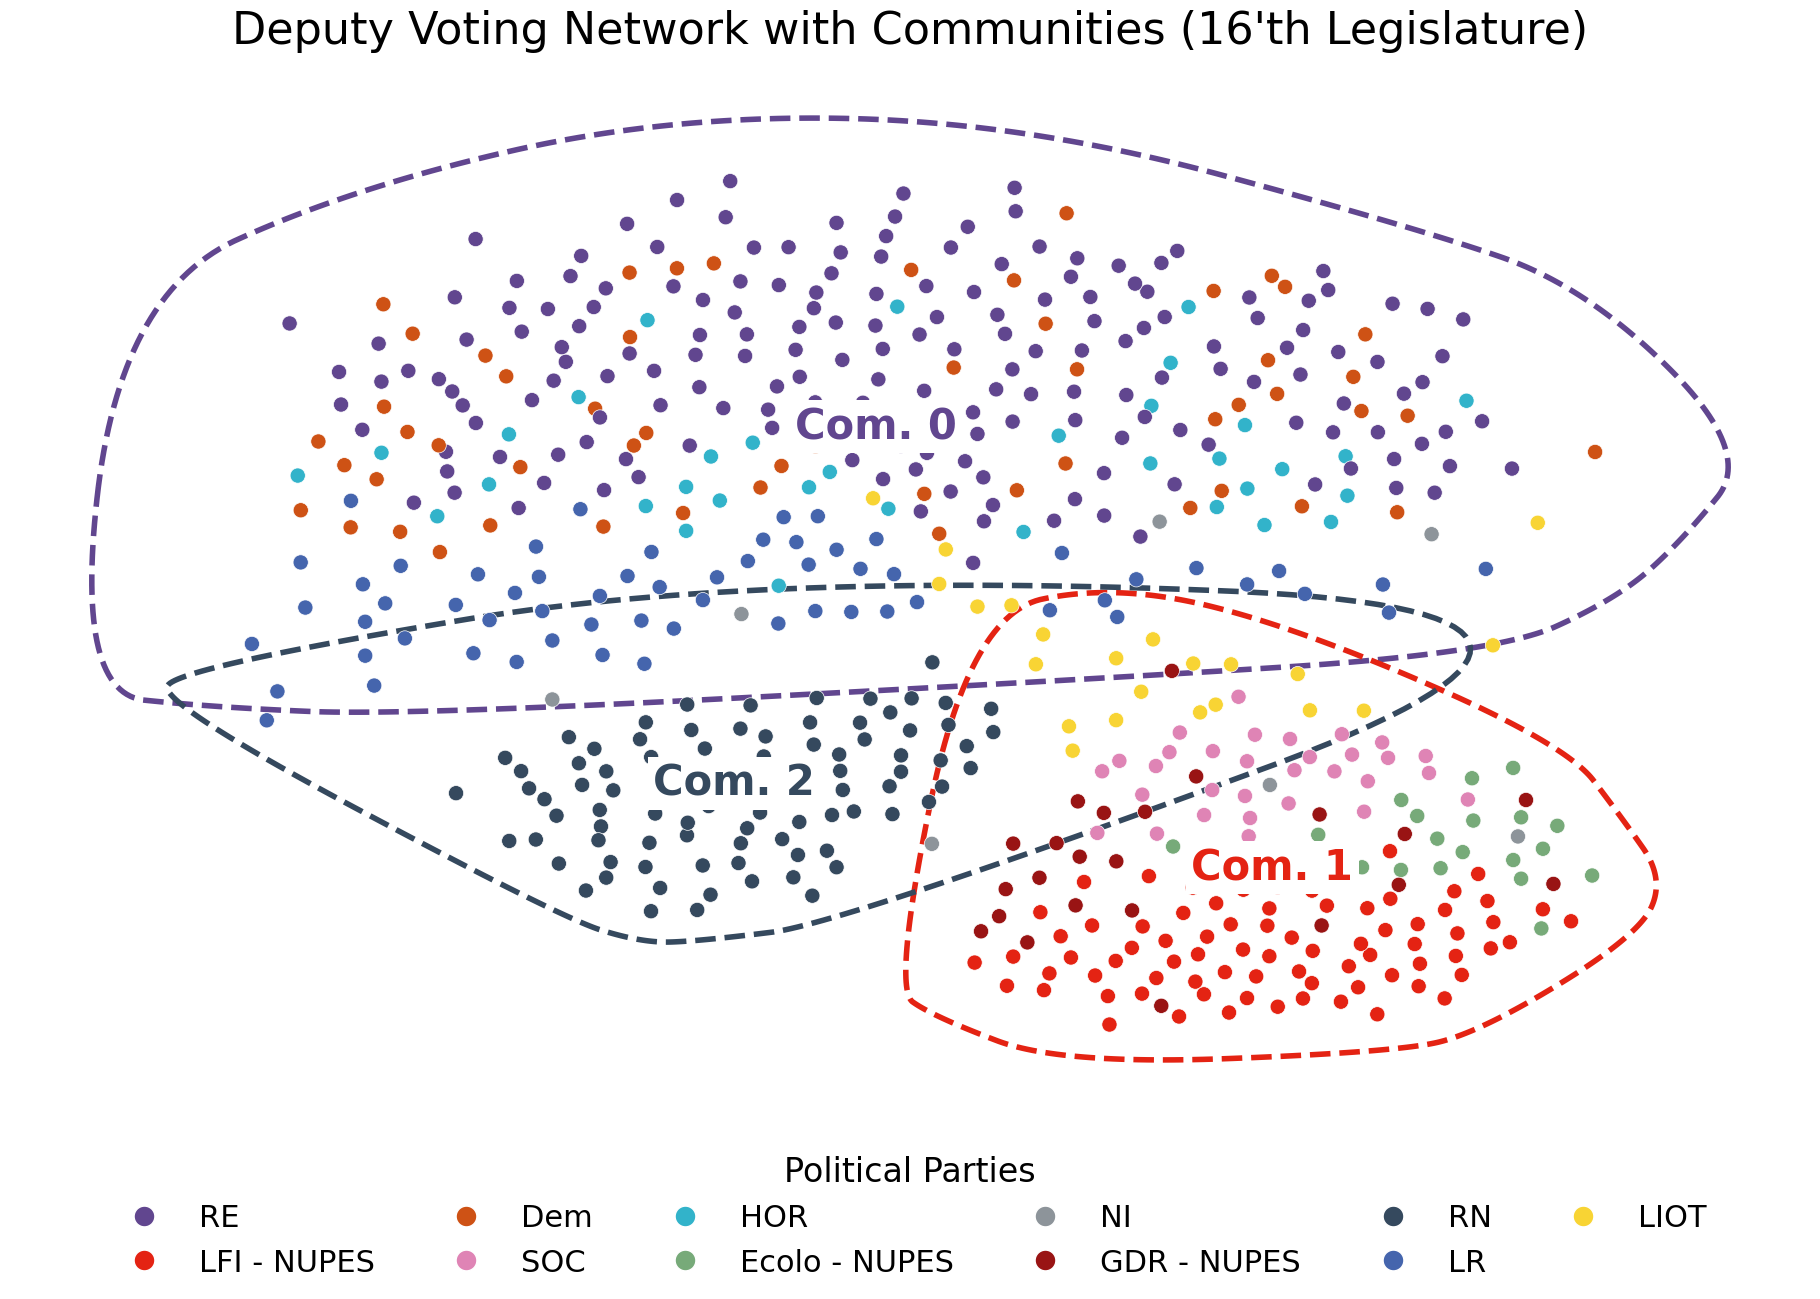

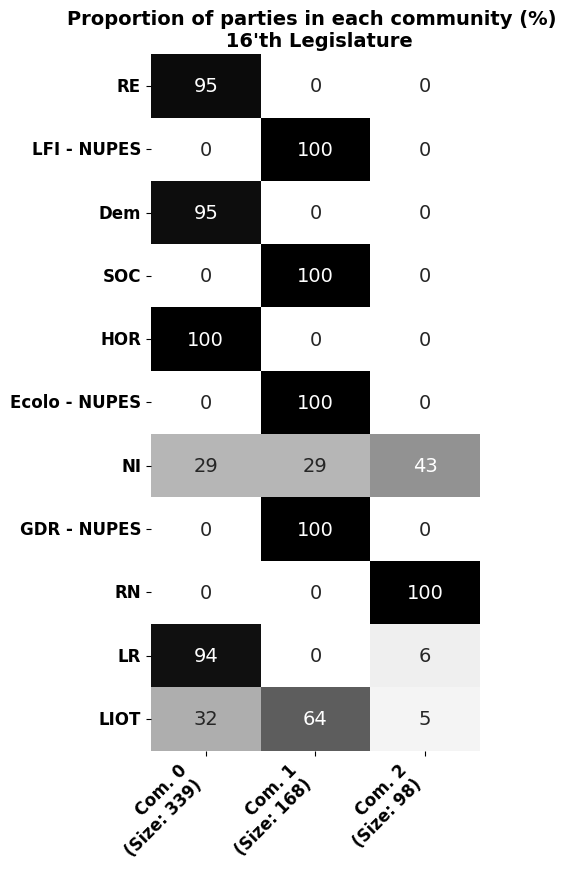

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\2970071050.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


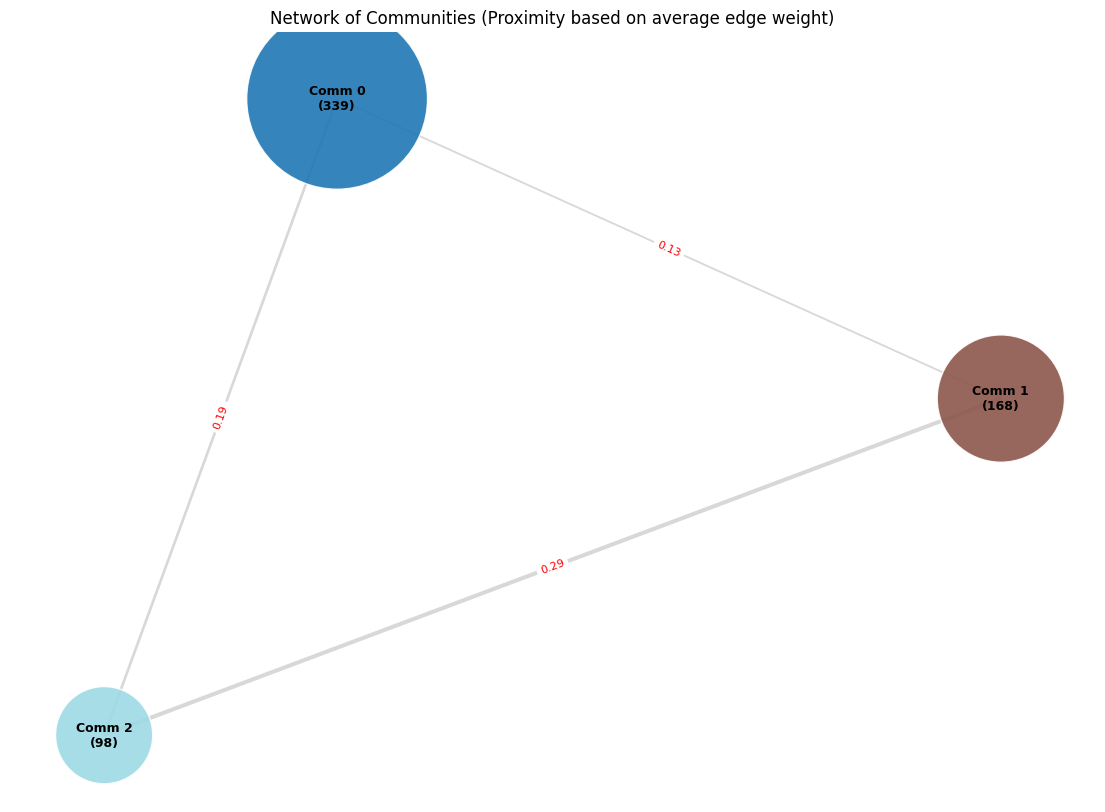

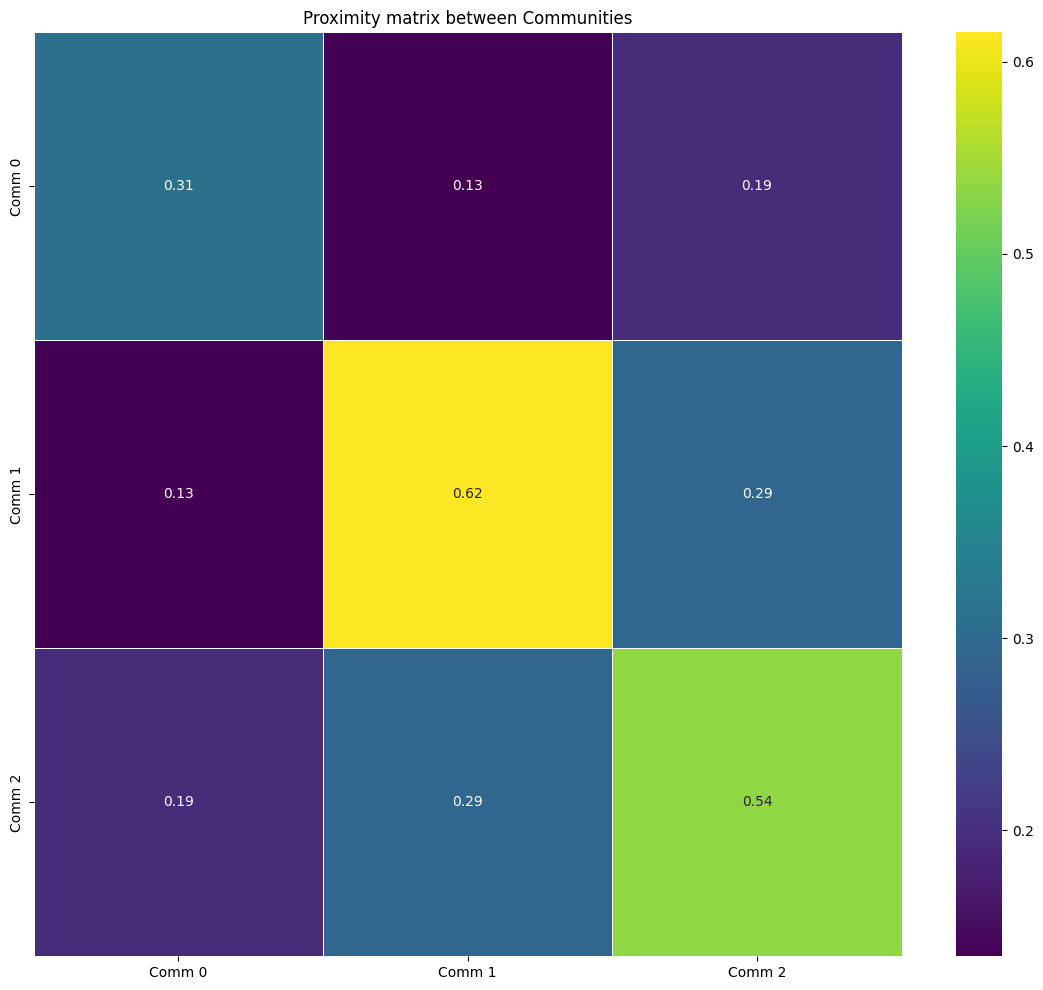

Stats: 3 inter-comm links, 106638 raw pairs, 182710 total pairs.


({(0, 1): np.float64(0.13436750702570738),
  (0, 2): np.float64(0.19343484419458684),
  (1, 2): np.float64(0.2917359723806231)},
 {('PA757225', 'PA794166'): 0.05785123966942149,
  ('PA757225', 'PA795298'): 0.029787234042553193,
  ('PA757225', 'PA793688'): 0.0625,
  ('PA757225', 'PA795820'): 0.07936507936507936,
  ('PA757225', 'PA721270'): 0.12413793103448276,
  ('PA757225', 'PA643192'): 0.11836734693877551,
  ('PA757225', 'PA794494'): 0.21311475409836064,
  ('PA757225', 'PA793664'): 0.056818181818181816,
  ('PA757225', 'PA793464'): 0.06878306878306878,
  ('PA757225', 'PA608695'): 0.12352941176470589,
  ('PA757225', 'PA795998'): 0.09154929577464789,
  ('PA757225', 'PA793796'): 0.15469613259668508,
  ('PA757225', 'PA722344'): 0.07407407407407407,
  ('PA757225', 'PA1008'): 0.09340659340659341,
  ('PA757225', 'PA791824'): 0.028,
  ('PA757225', 'PA605745'): 0.0582010582010582,
  ('PA757225', 'PA795430'): 0.1532258064516129,
  ('PA757225', 'PA795580'): 0.04672897196261682,
  ('PA757225', 'PA

In [29]:
plot_network(G_16, legislature_16["deputies"], 16)
communities_set, modularity_score = plot_network_with_communities(G_16,legislature_16["deputies"], 16)
organ_name_dict, partis_members = get_party_info(legislature_16["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_16["deputies"].keys()), 16)

analyze_community_proximity(G_16, communities_set, legislature_16["deputies"], plot=True)

### Legislature 15

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\1348156239.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


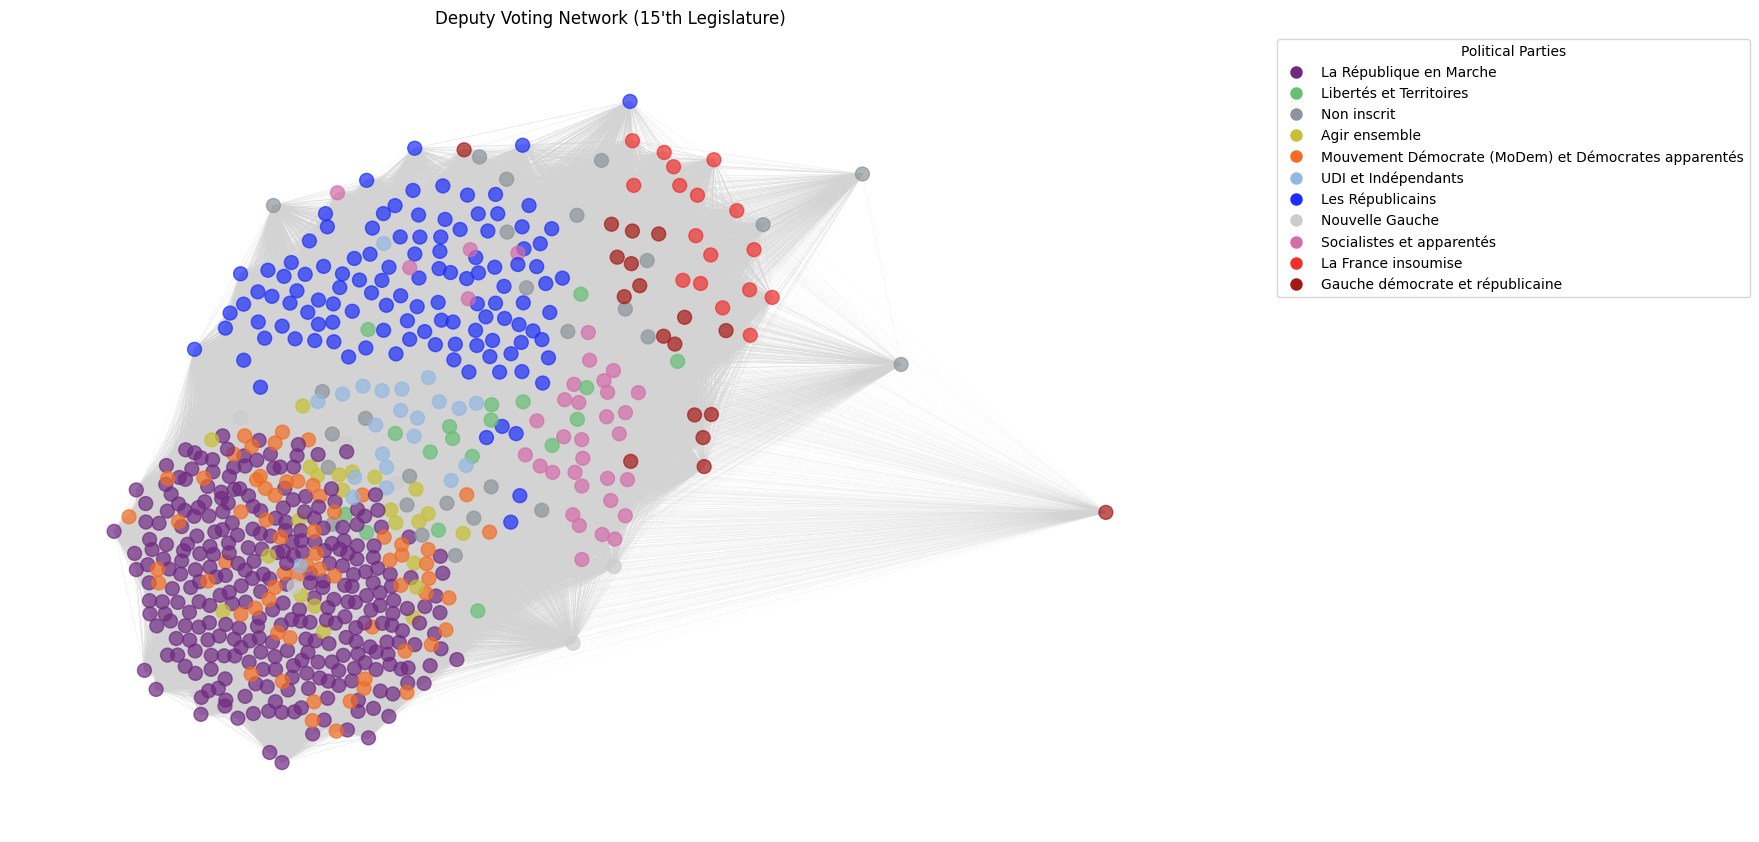

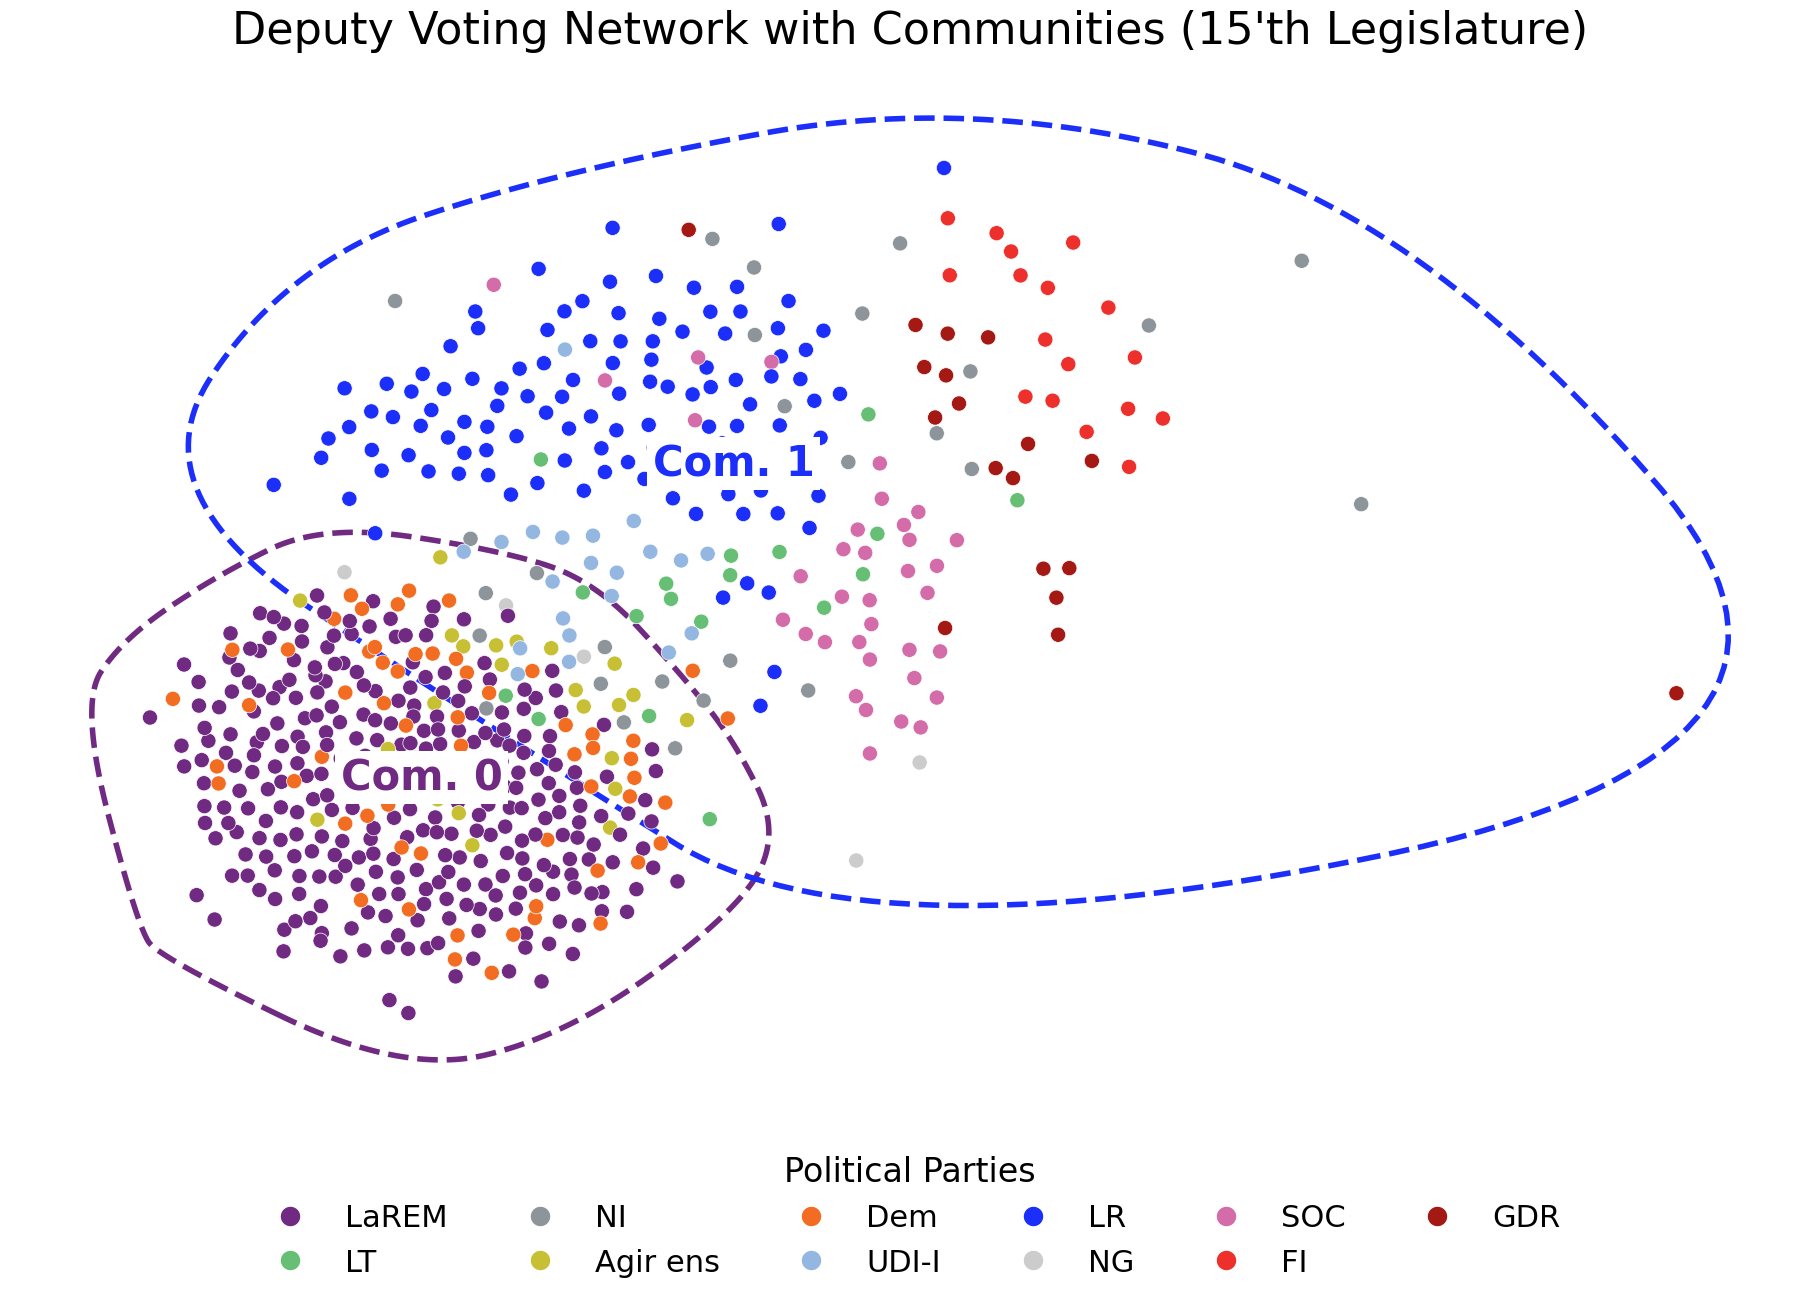

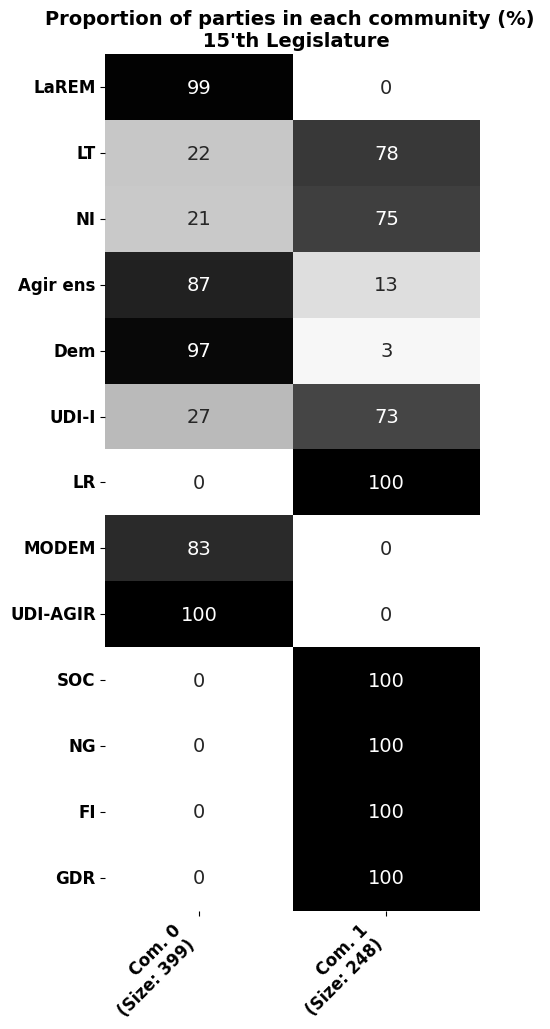

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\2970071050.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


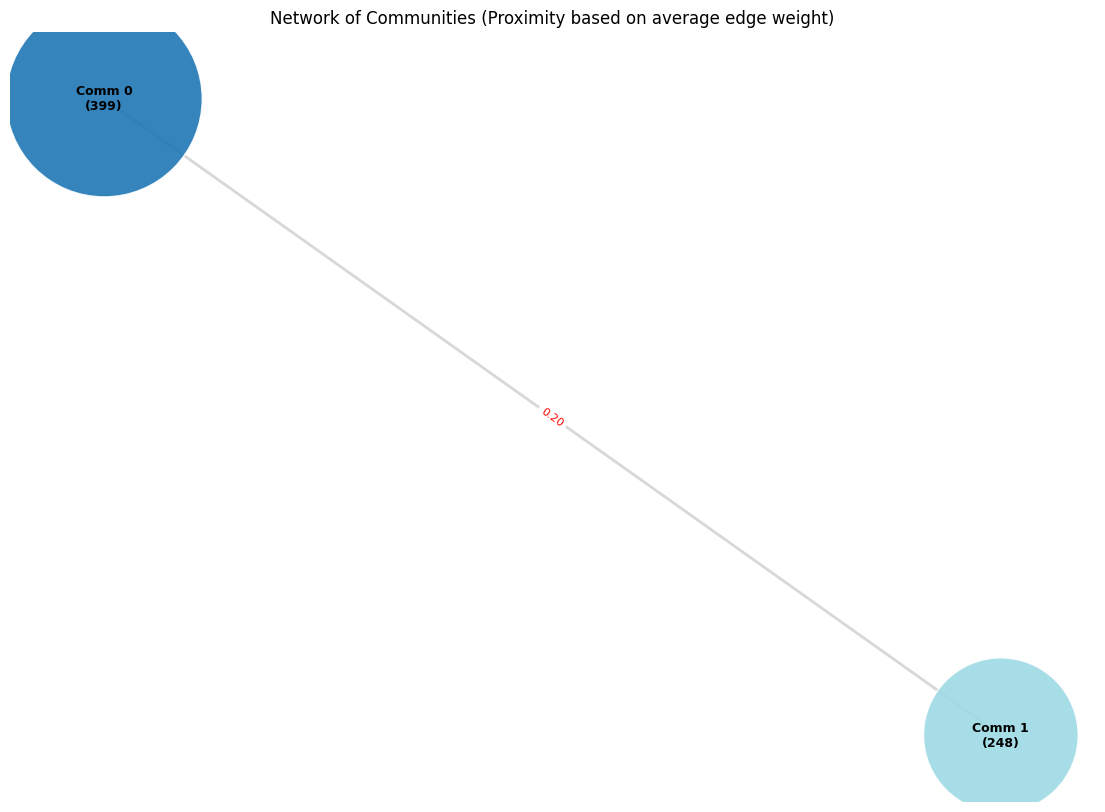

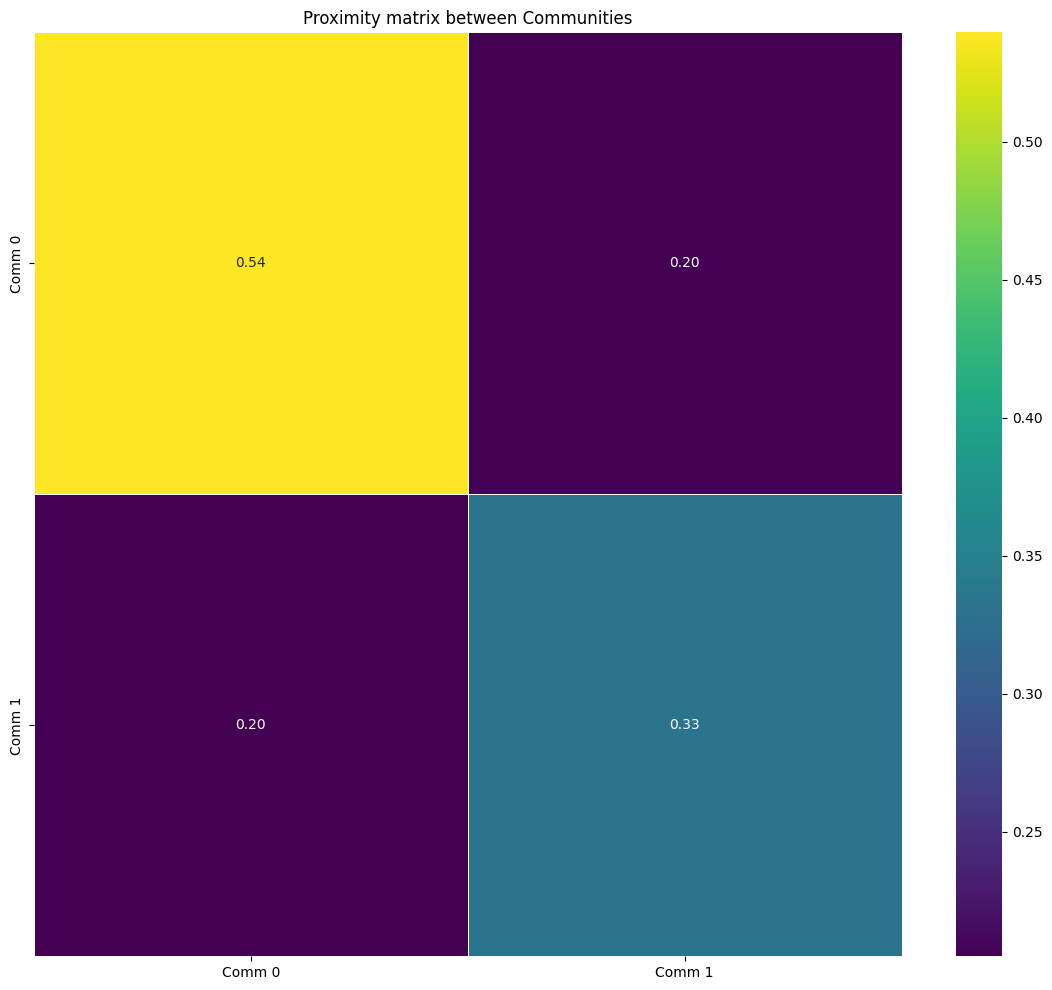

Stats: 1 inter-comm links, 98952 raw pairs, 208981 total pairs.


({(0, 1): np.float64(0.20490554223633253)},
 {('PA720268', 'PA721486'): 0.27906976744186046,
  ('PA720268', 'PA721816'): 0.16666666666666666,
  ('PA720268', 'PA609245'): 0.17733990147783252,
  ('PA720268', 'PA721270'): 0.10743801652892562,
  ('PA720268', 'PA643192'): 0.2184873949579832,
  ('PA720268', 'PA718784'): 0.182370820668693,
  ('PA720268', 'PA267289'): 0.1984732824427481,
  ('PA720268', 'PA721636'): 0.21176470588235294,
  ('PA720268', 'PA608695'): 0.21201413427561838,
  ('PA720268', 'PA1498'): 0.18604651162790697,
  ('PA720268', 'PA330240'): 0.175,
  ('PA720268', 'PA721226'): 0.07416267942583732,
  ('PA720268', 'PA267766'): 0.3051643192488263,
  ('PA720268', 'PA1008'): 0.11564625850340136,
  ('PA720268', 'PA923'): 0.15300546448087432,
  ('PA720268', 'PA719806'): 0.2828282828282828,
  ('PA720268', 'PA721576'): 0.12698412698412698,
  ('PA720268', 'PA721410'): 0.1396508728179551,
  ('PA720268', 'PA643134'): 0.13934426229508196,
  ('PA720268', 'PA719146'): 0.13100436681222707,
  ('

In [30]:
plot_network(G_15, legislature_15["deputies"], 15)
communities_set, modularity_score = plot_network_with_communities(G_15,legislature_15["deputies"], 15)
organ_name_dict, partis_members = get_party_info(legislature_15["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_15["deputies"].keys()), 15)

analyze_community_proximity(G_15, communities_set, legislature_15["deputies"], plot=True)

### Legsilature 14

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\1348156239.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


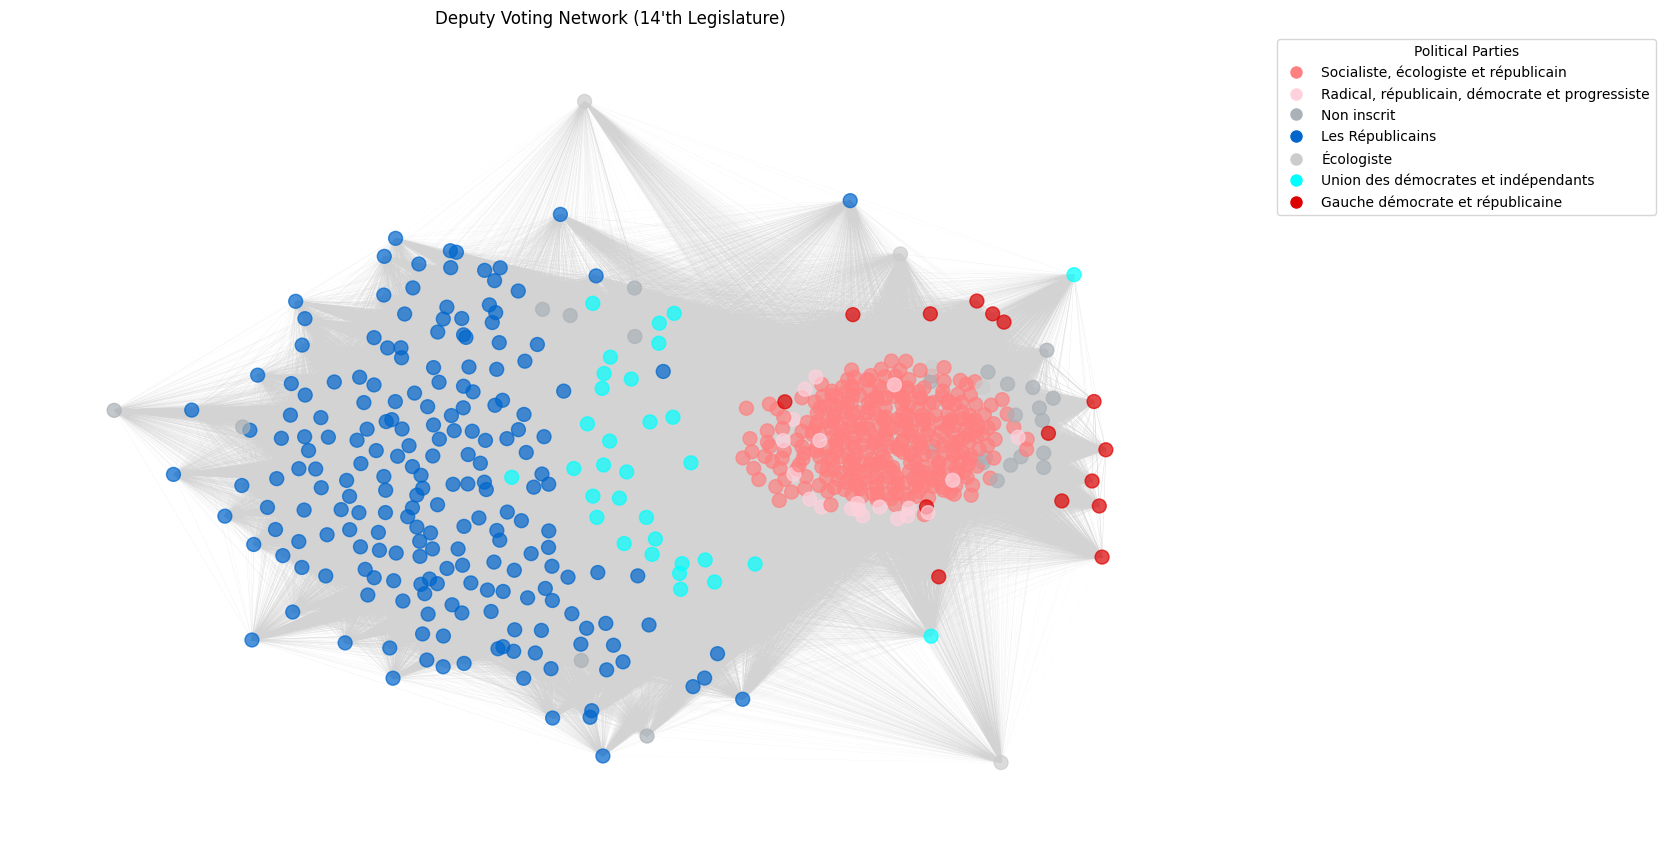

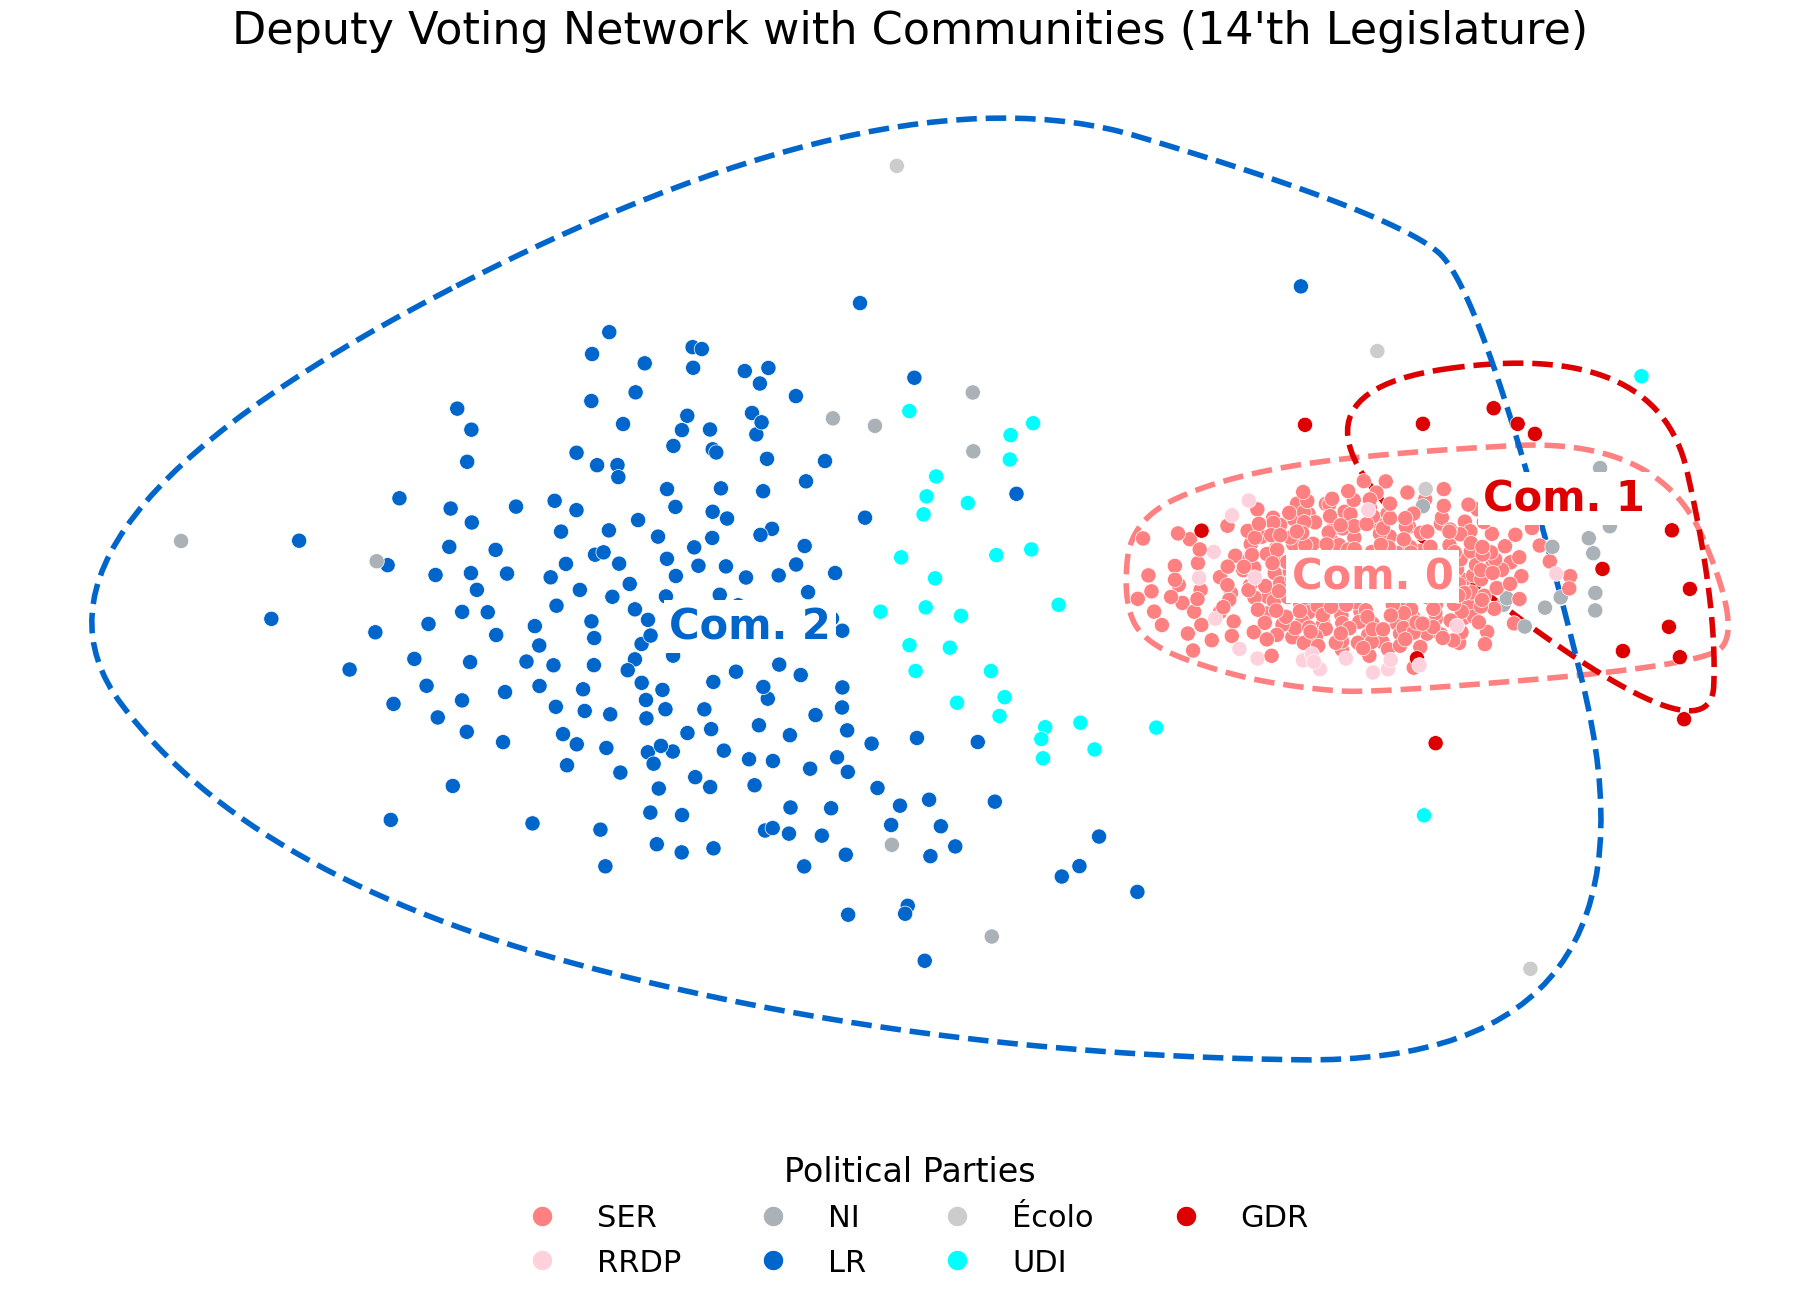

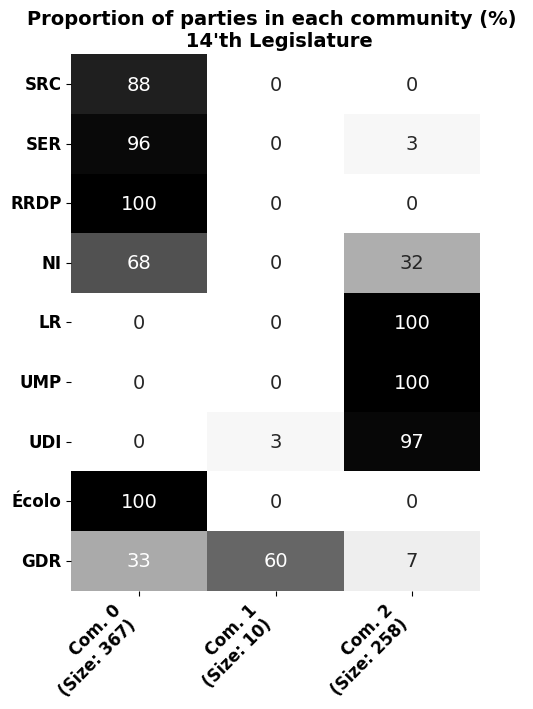

C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\2970071050.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


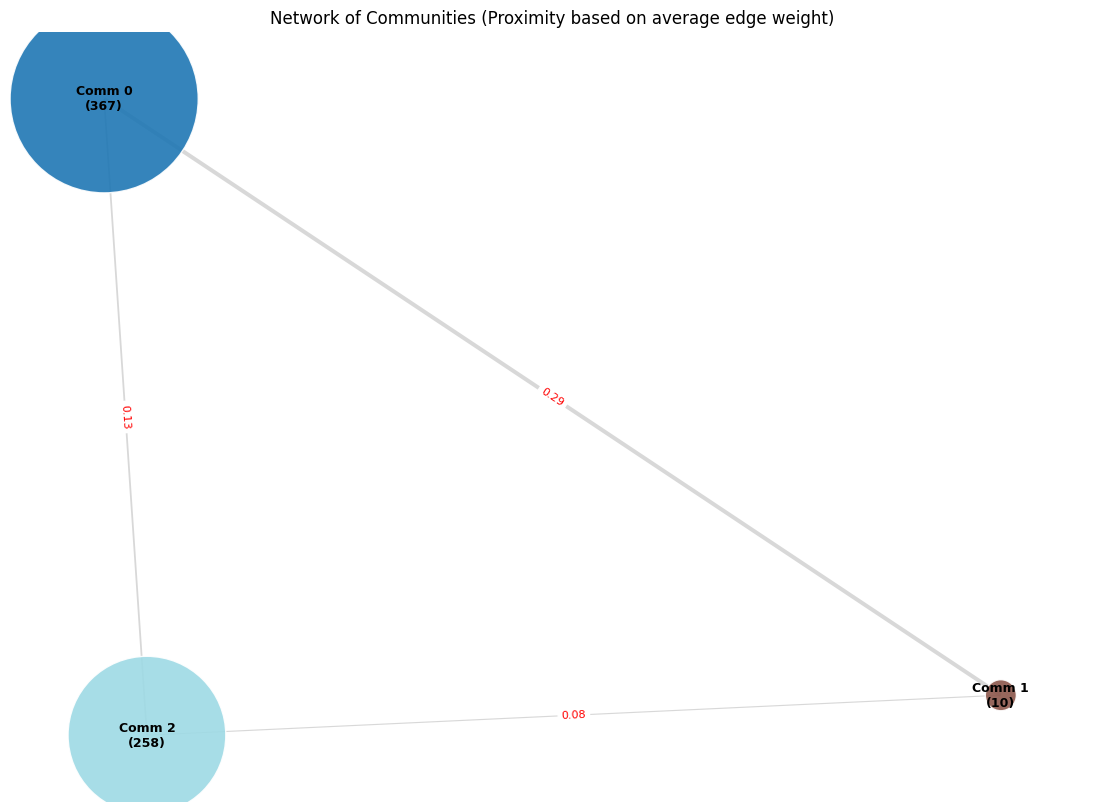

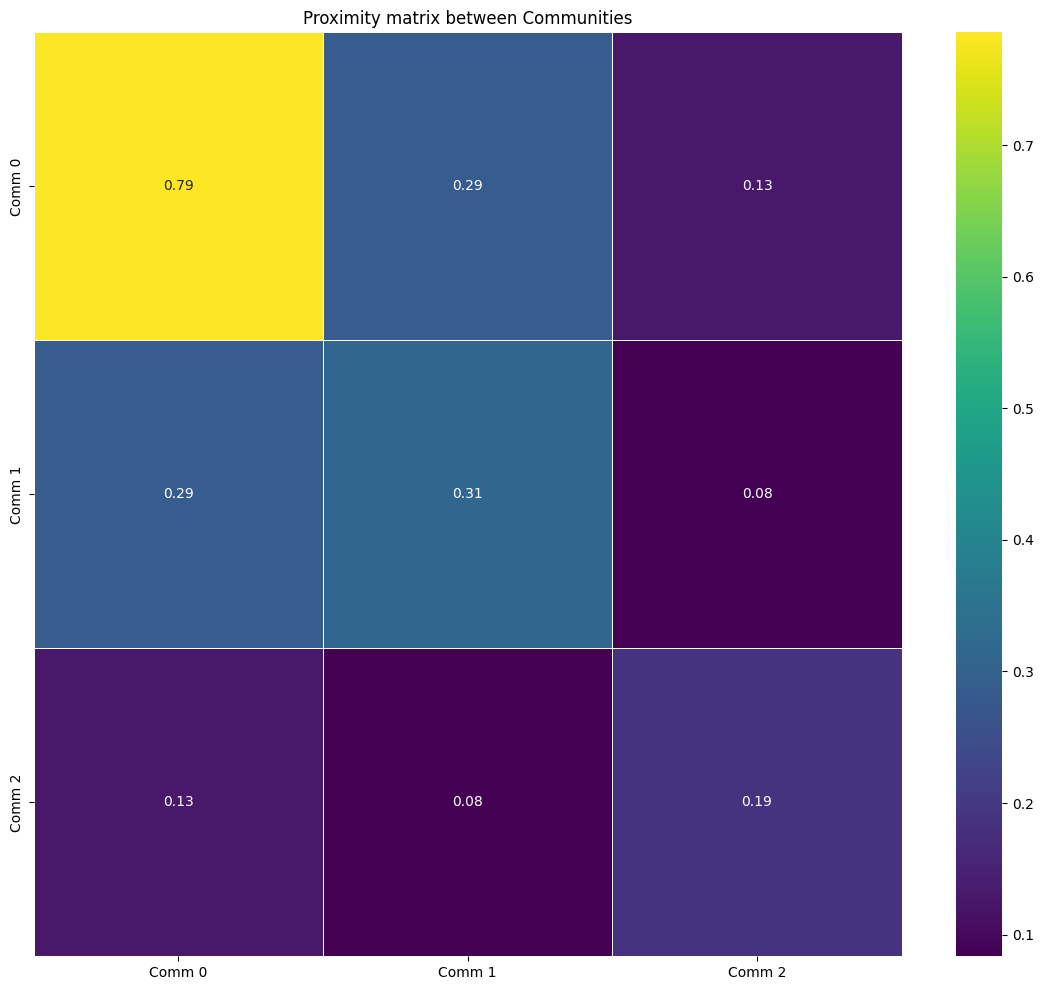

Stats: 3 inter-comm links, 100936 raw pairs, 201295 total pairs.


({(0, 1): np.float64(0.2886787729907264),
  (0, 2): np.float64(0.13004579316553538),
  (1, 2): np.float64(0.0835191984576745)},
 {('PA610905', 'PA1141'): 0.37410071942446044,
  ('PA610905', 'PA267492'): 0.29838709677419356,
  ('PA610905', 'PA605745'): 0.28346456692913385,
  ('PA610905', 'PA340755'): 0.29133858267716534,
  ('PA610905', 'PA1373'): 0.2,
  ('PA610905', 'PA754'): 0.208955223880597,
  ('PA610905', 'PA267306'): 0.33093525179856115,
  ('PA610905', 'PA689'): 0.3409090909090909,
  ('PA610905', 'PA551'): 0.3177570093457944,
  ('PA610905', 'PA1364'): 0.3191489361702128,
  ('PA1991', 'PA1141'): 0.3469387755102041,
  ('PA1991', 'PA267492'): 0.2773722627737226,
  ('PA1991', 'PA605745'): 0.2482758620689655,
  ('PA1991', 'PA340755'): 0.27941176470588236,
  ('PA1991', 'PA1373'): 0.2033898305084746,
  ('PA1991', 'PA754'): 0.19863013698630136,
  ('PA1991', 'PA267306'): 0.2929936305732484,
  ('PA1991', 'PA689'): 0.32142857142857145,
  ('PA1991', 'PA551'): 0.29914529914529914,
  ('PA1991', 

In [31]:
plot_network(G_14, legislature_14["deputies"], 14)
communities_set, modularity_score = plot_network_with_communities(G_14,legislature_14["deputies"], 14)
organ_name_dict, partis_members = get_party_info(legislature_14["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_14["deputies"].keys()), 14)
analyze_community_proximity(G_14, communities_set, legislature_14["deputies"], plot=True)

### More detail about legislature 17

Number of nodes: 611
Number of edges: 179915
Average degree: 588.92
Graph has 9 connected components


C:\Users\tchir\AppData\Local\Temp\ipykernel_29876\1348156239.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


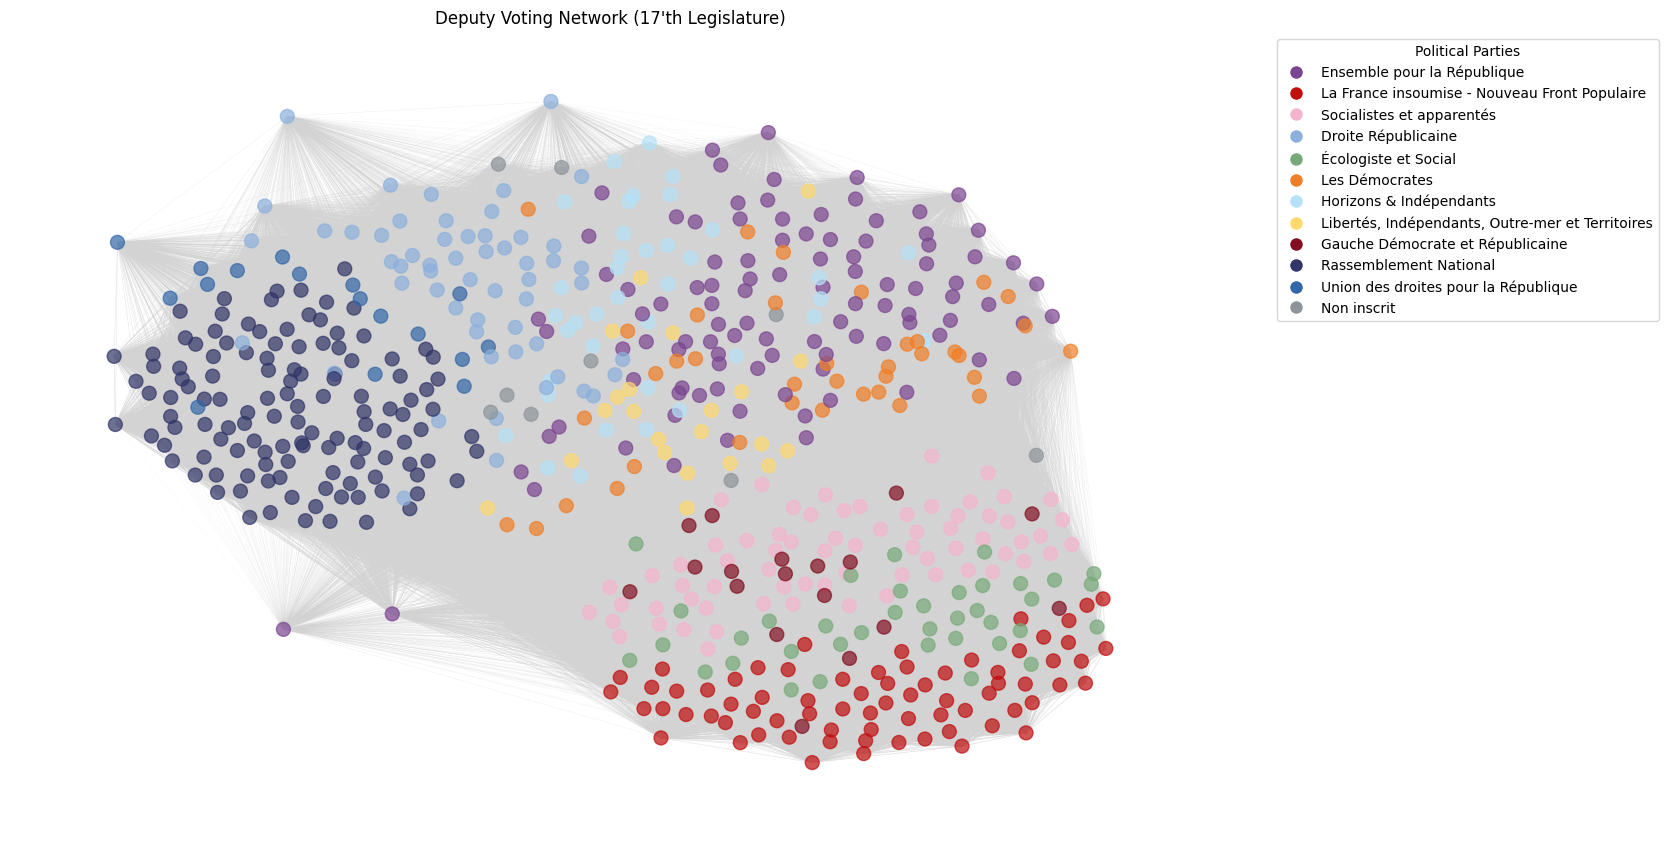

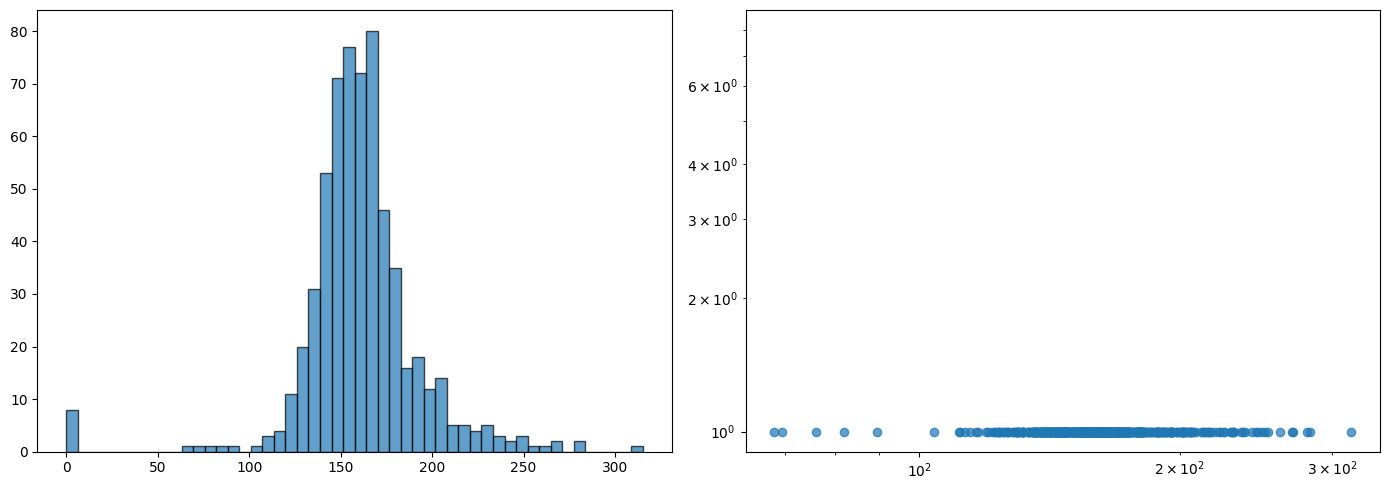

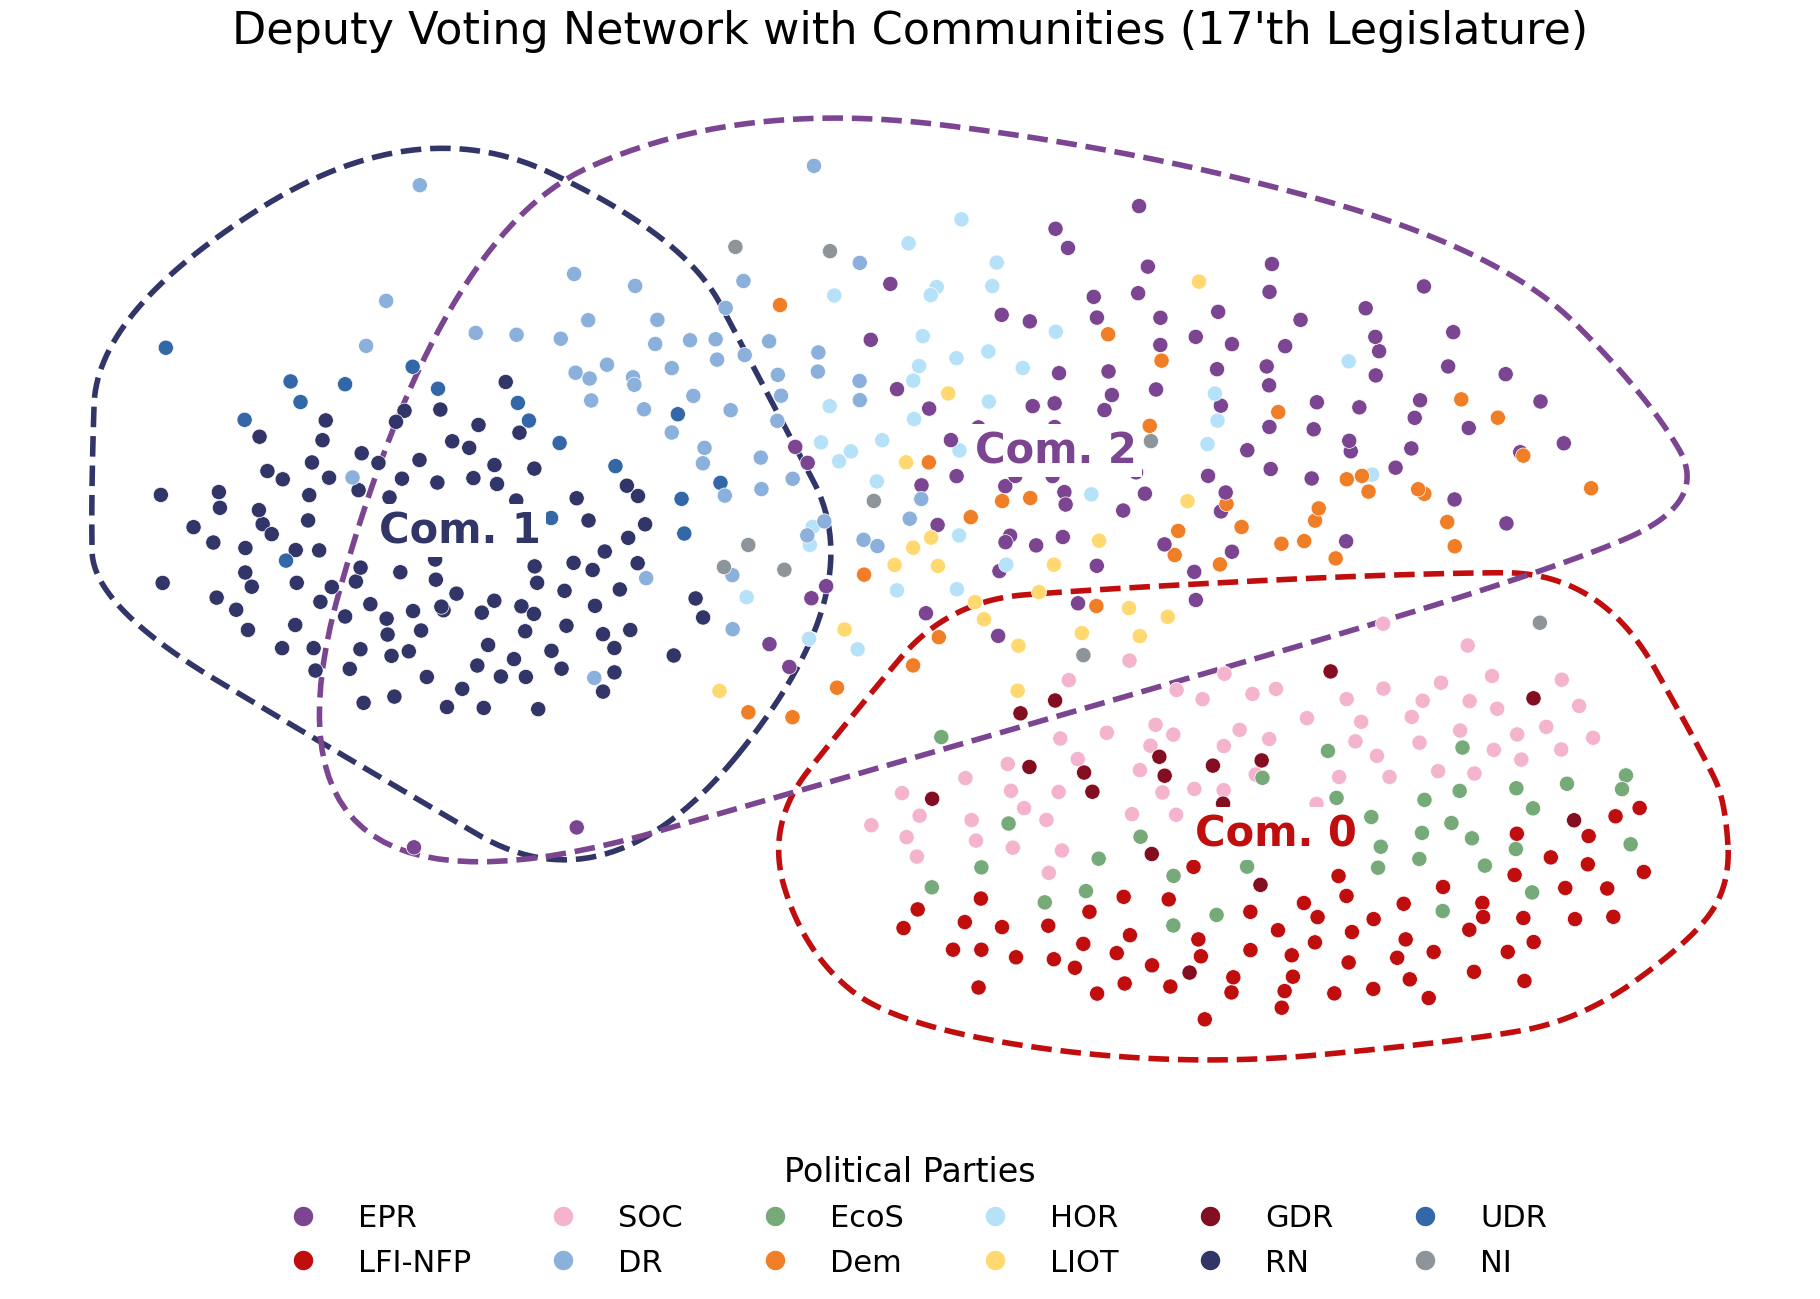

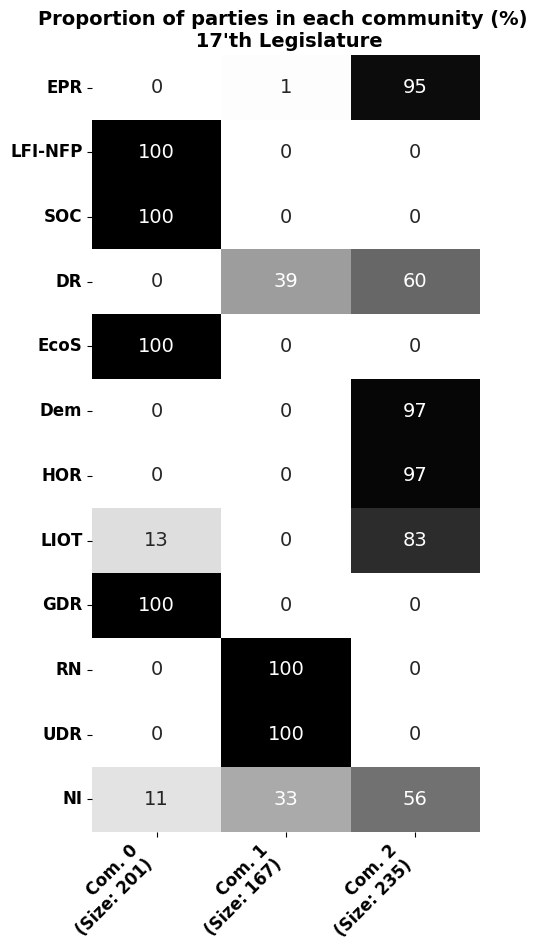

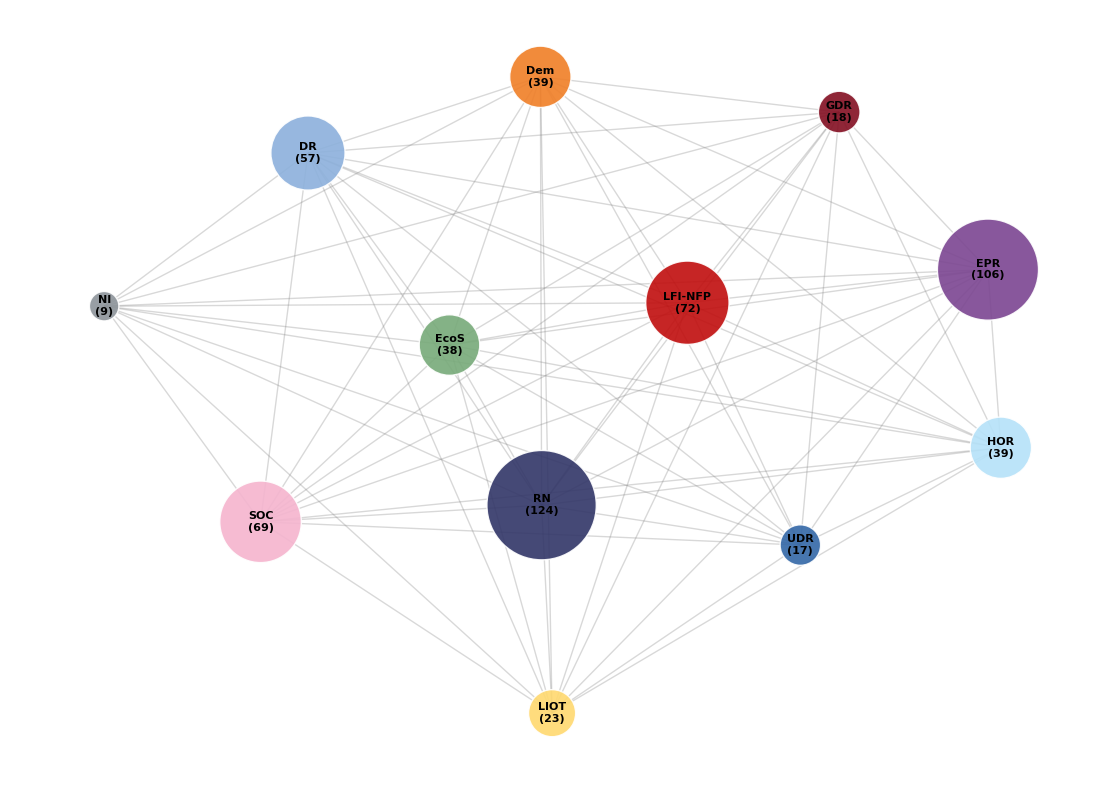

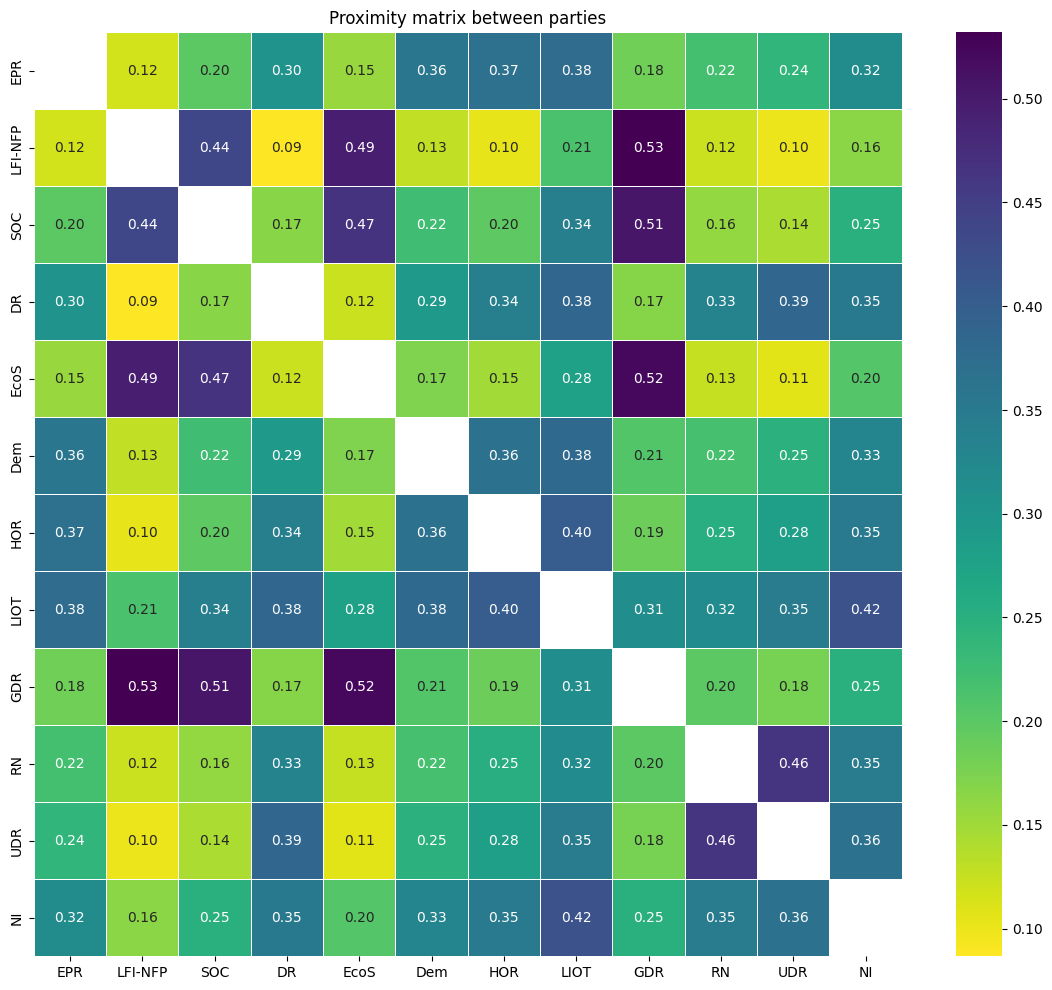

66 159619 181503 21884 12
Modularity score - partis : 0.08545757353777723


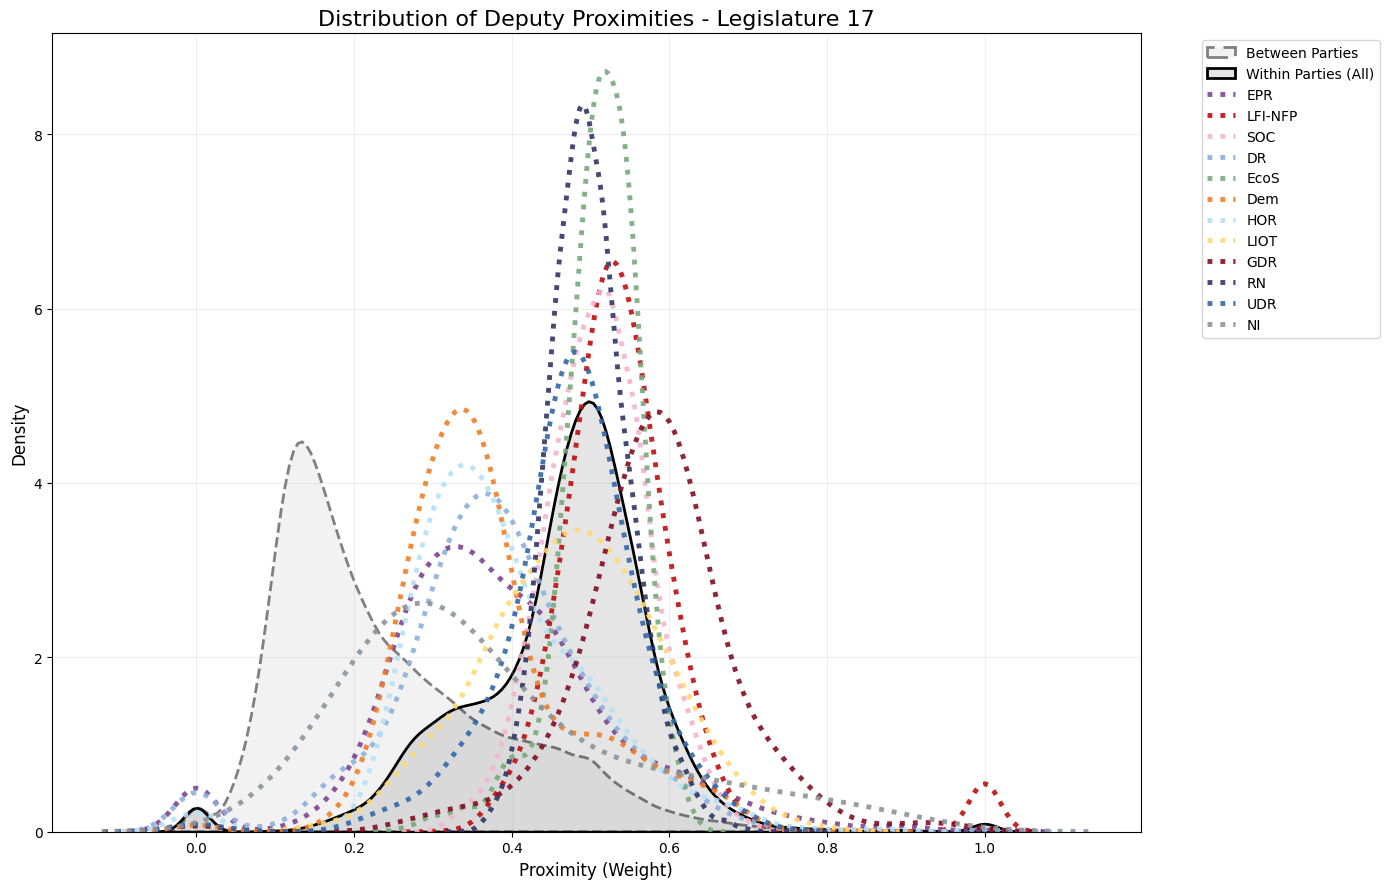

In [25]:
G = create_graph(legislature_17["deputies"], legislature_17["votes"])
print_stats(G)
G_sample = get_giant_component(G)
plot_network(G_sample, legislature_17["deputies"], 17)
plot_degree_distribution(G)
communities_set, modularity_score = plot_network_with_communities(G_17,legislature_17["deputies"], 17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()), 17)
proximites_partis = analyze_party_proximity(G_sample, partis_members, organ_name_dict, legislature_17["deputies"], True)
calculate_party_modularity(G_sample, partis_members)
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)

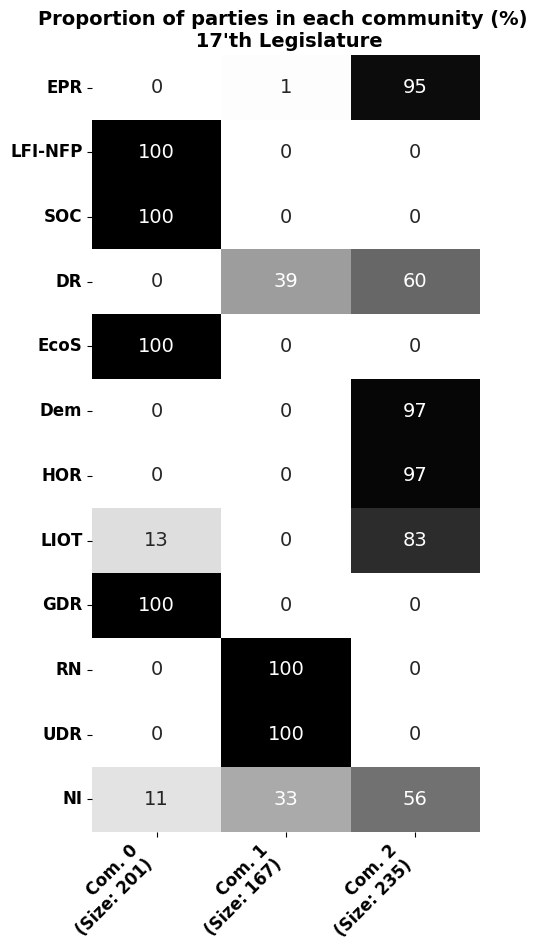

In [26]:
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()), 17)
